<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="float:right; max-width: 250px; display: inline"  alt="Wikistat"/></a>
</center>

# [Scénarios d'Apprentissage Statistique](https://github.com/wikistat/Apprentissage)

#  Adaptation Statistique d'un Modèle de Prévision du Pic d'Ozone avec <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>

**Résumé**: Exploration puis modélisation de données climatiques en utilisant R. L'objectif est de prévoir pour le lendemain un possible dépassement d'un seuil de concentration en ozone à partir d'une prévision déterministe sur un maillage grossier et de variables climatiques locales. Estimation par différentes méthodes : régression [linéaire](http://wikistat.fr/pdf/st-m-app-select.pdf) ou   [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [agrégation de modèle](http://wikistat.fr/pdf/st-m-app-agreg.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf). Comparaison des [erreurs de prévision](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf) sur un échantillon test puis des courbes ROC. Industrialisaiton avec le package `caret` et itération sur plusieurs échantillons tests pour analyser la distribution de l'erreur de prévision.

**Avertissement** 

* Ce tutoriel est découpé en 5 séances / épisodes de travaux dirigés syncronisées avec le cours d'apprentissage machine. 
* Réfléchir aux réponses aux questions marquées **Q** issues du sujet d'examen.
* Ce calepin est complété par celui en Python (à faire _après_, ou en parallèle) afin de comparer les performances respectives des deux environnements. 

## Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

Toutes les opérations sont réalisées dans R avec l'appui de bibliothèques complémentaires éventuellement à télécharger (`corrplot, FactoMineR, glmnet, ROCR, mlbench, MASS, boot, class, e1071, rpart, partykit, nnet, ipred, gbm, randomForest, caret, doParallel, xgboost, missForest, Rlof, dbscan, kernlab`). 

Python (consulter le [calepin](https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-Python-Ozone.ipynb)) conduit à des résultats comparables mais moins complets pour leur interprétation. En particulier, l'absence du type *DataFrame* dans la librairie scikit-learn n'autorise pas une sélection fine des variables dans les modèles statistiques usuels. En revanche, l'exécution de la validation croisée Monte Carlo est plus rapide en python.

# <FONT COLOR="Red">Épisode 1</font>

## Prise en charge des données

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** : type de jour ; férié (1) ou pas (0) ;
* **O3obs** : concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** : prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** : température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** : rapport d'humidité ;
* **NO2** : concentration en dioxyde d'azote ;
* **NO** : concentration en monoxyde d'azote ;
* **STATION** : lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** : force du vent ;
* **VentANG** : orientation du vent. 

Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention**: Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

In [1]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""),
                    sep = ",", header = TRUE)
# Vérification du contenu
summary(ozone)

      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [2]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

## Exploration élémentaire

Remarquer le type des variables. Il est nécessaire d'en étudier la distribution. Noter la symétrie ou non de celles-ci.

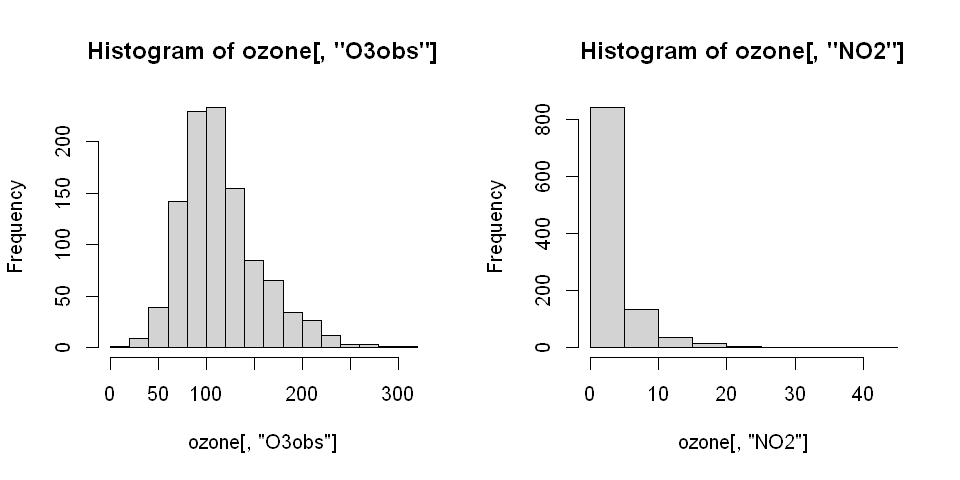

In [3]:
par(mfrow = c(1, 2))
options(repr.plot.width = 8, repr.plot.height = 4)
hist(ozone[, "O3obs"])
hist(ozone[, "NO2"])

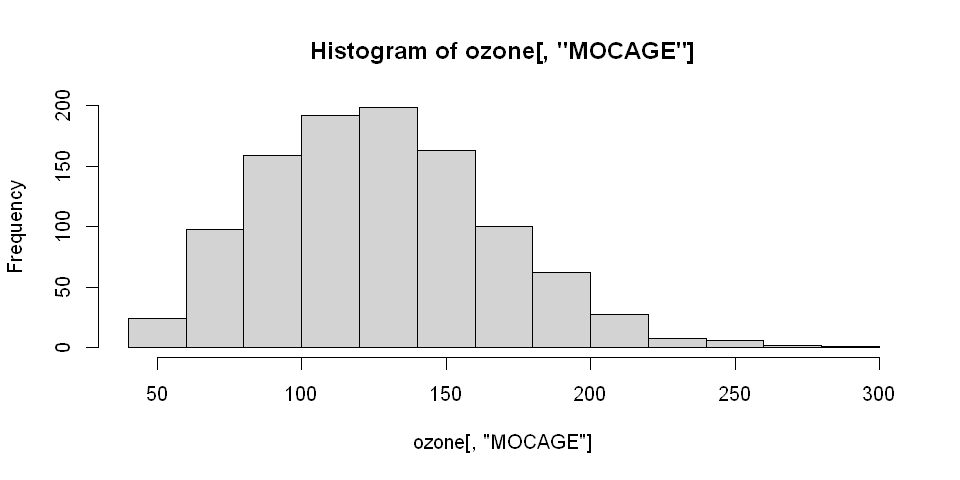

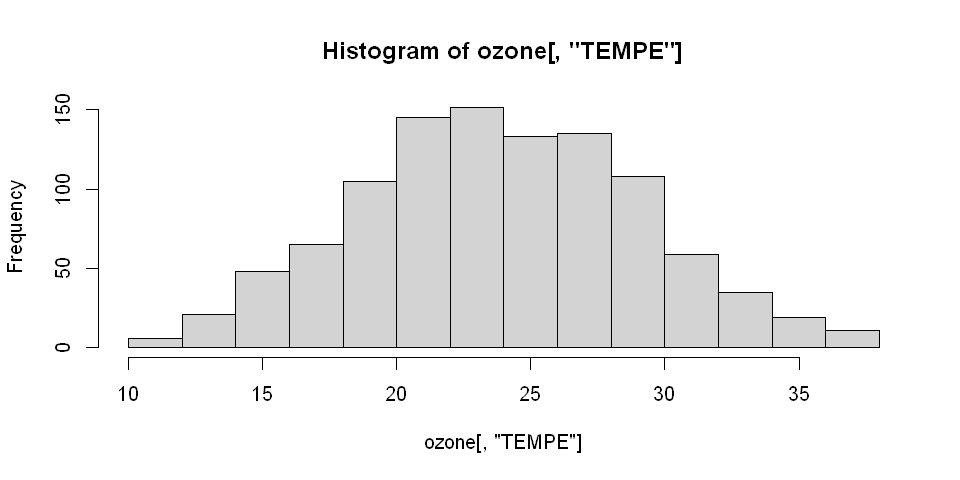

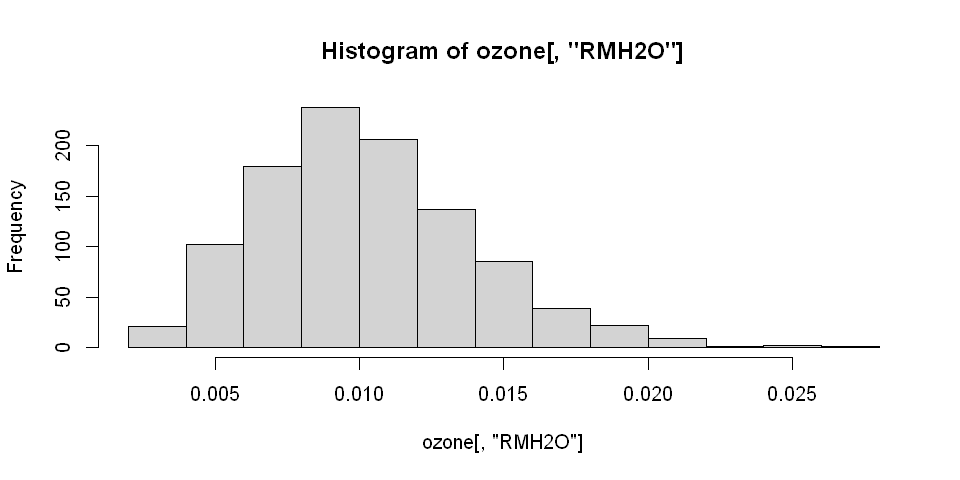

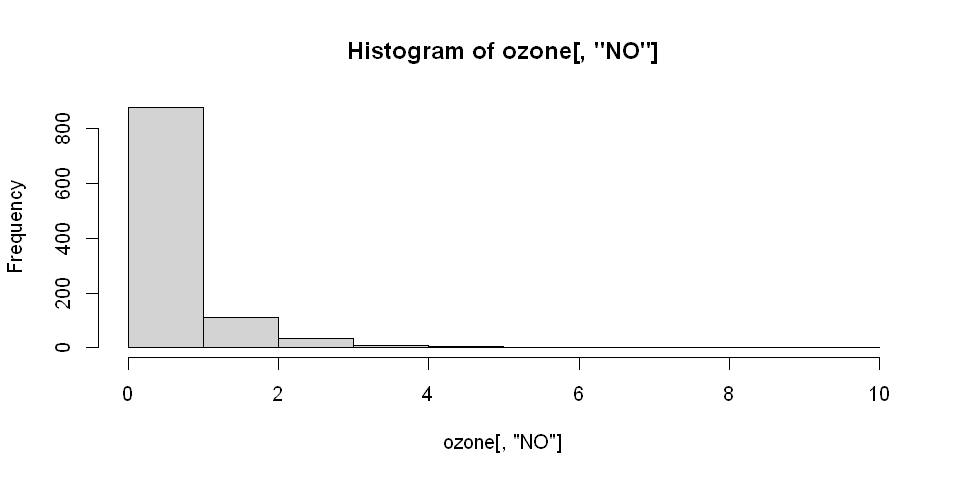

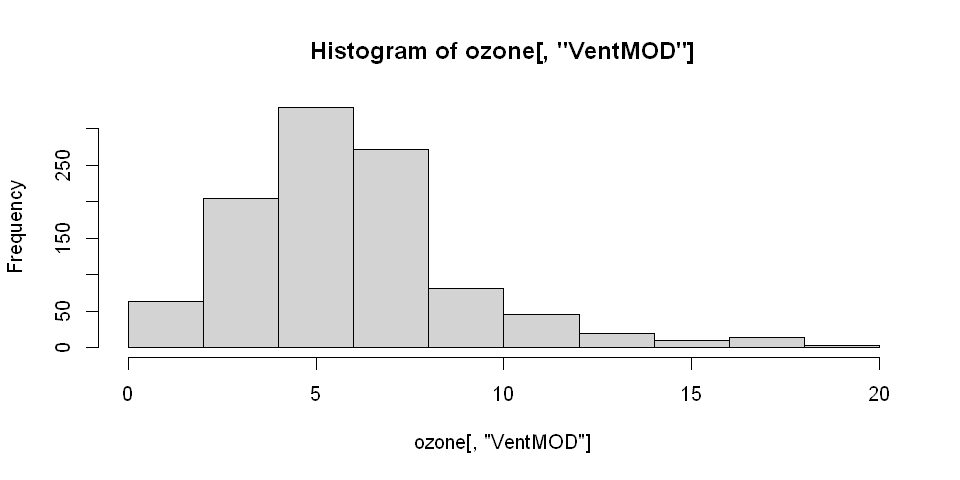

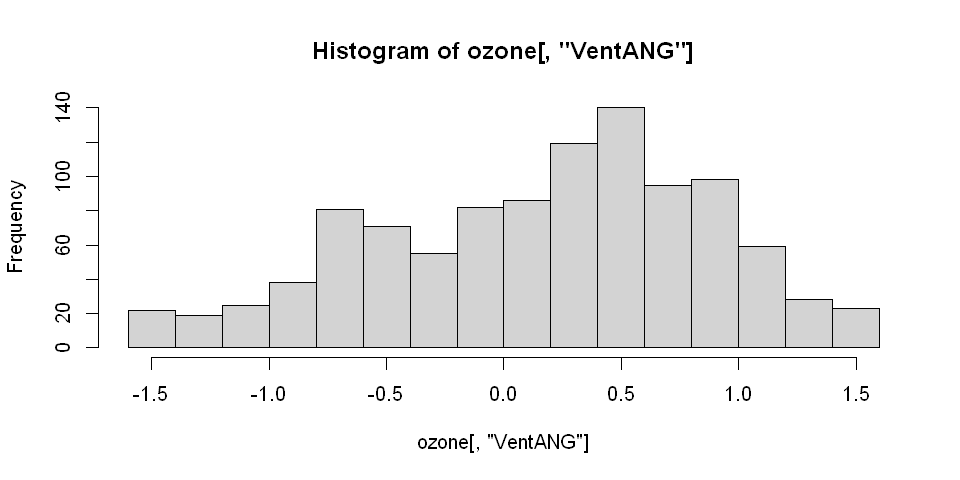

In [4]:
# Même chose pour les autres variables
hist(ozone[,"MOCAGE"]);hist(ozone[,"TEMPE"]);hist(ozone[,"RMH2O"])
hist(ozone[,"NO"]);hist(ozone[,"VentMOD"]);hist(ozone[,"VentANG"])

Des transformations sont proposées pour rendre certaines distributions plus symétriques et ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir de modélisation (linéaires), par pour toutes (arbres).

In [5]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

Vérifier l'opportunité de ces transformations puis retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.


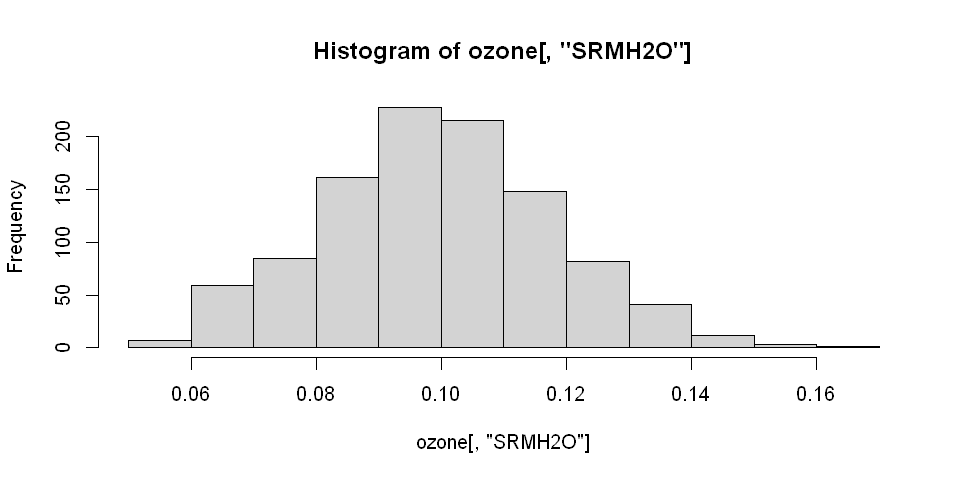

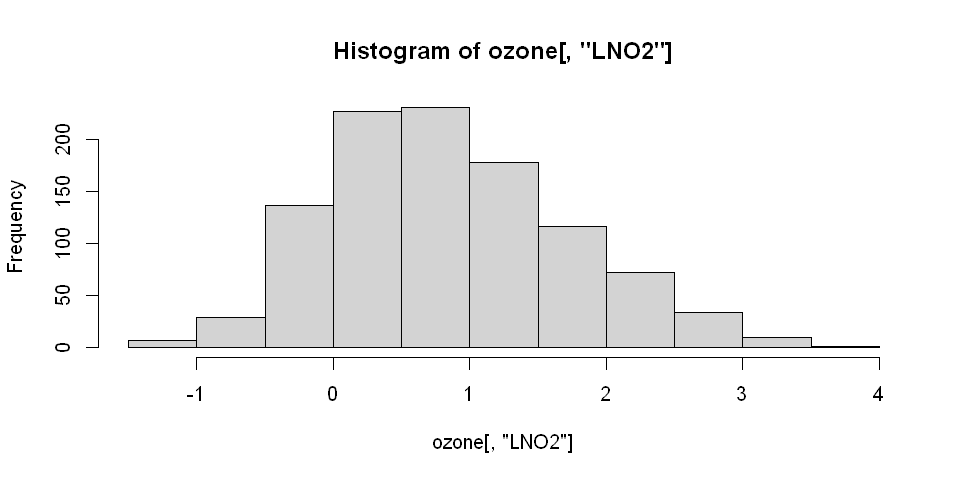

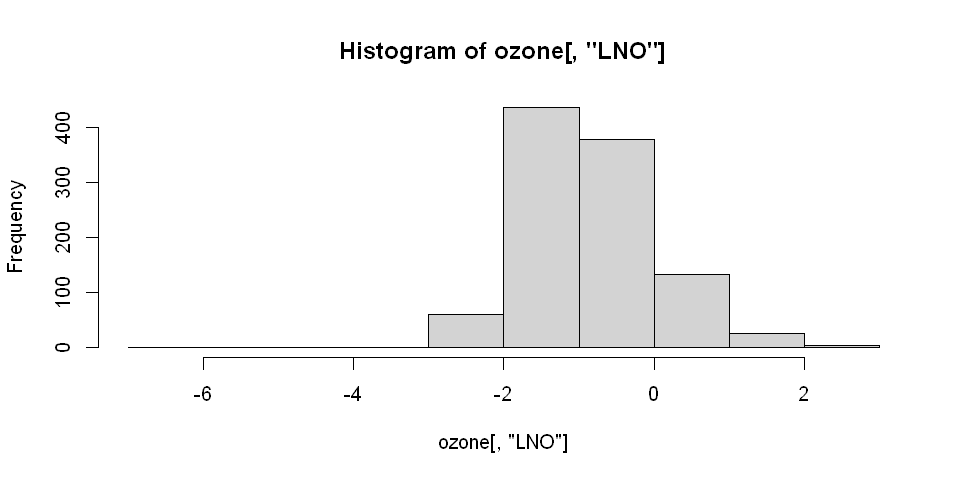

In [6]:
hist(ozone[, "SRMH2O"])
hist(ozone[, "LNO2"])
hist(ozone[, "LNO"])

In [7]:
depassement_de_seuil <- as.factor(ozone[, "O3obs"] > 150)

In [8]:
ozone <- ozone[, c(1:4, 8:13)]
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

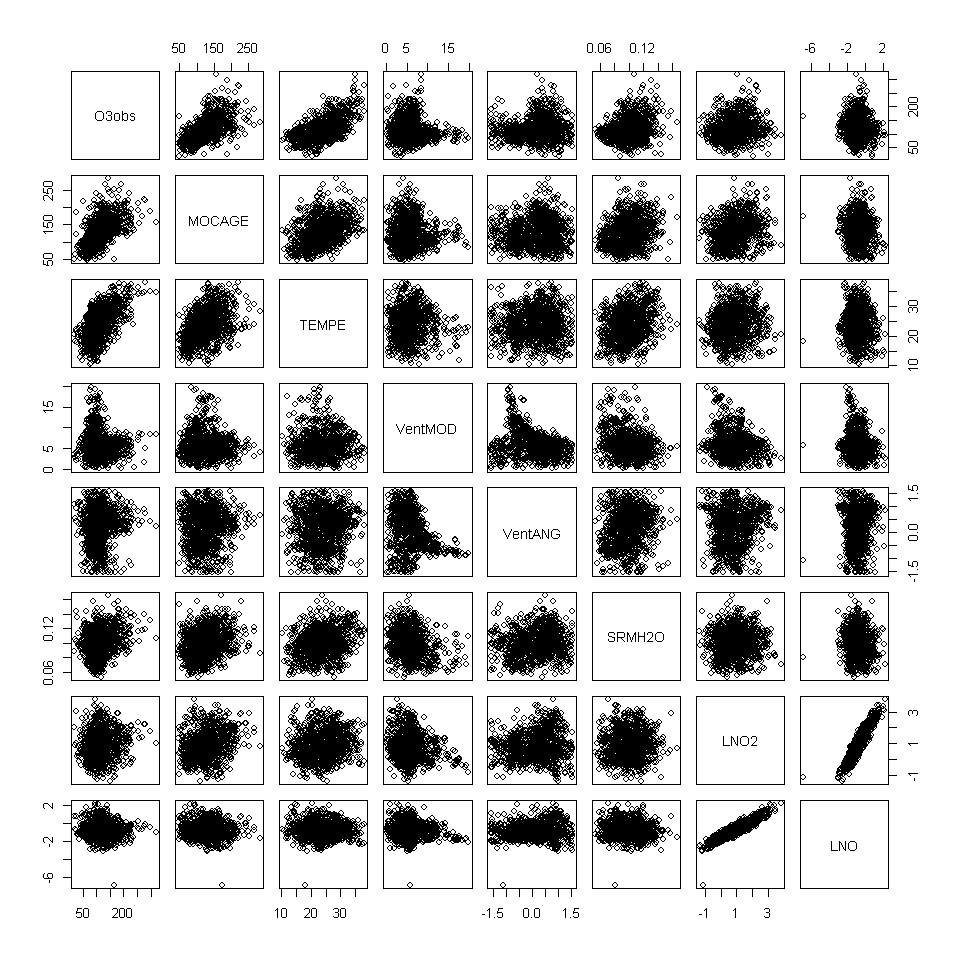

In [9]:
options(repr.plot.width = 8, repr.plot.height = 8)
pairs(ozone[, c(2:4, 6:10)])

**Q** Que dire sur les relations des varibles 2 à 2 ?

Les variables ne semblent pas corrélées sauf pour les variables en bas à droite : on observe une droite.

**Q** Compléter en visualisant les corrélations avec la fonction 'corrplot' (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ? 

corrplot 0.84 loaded



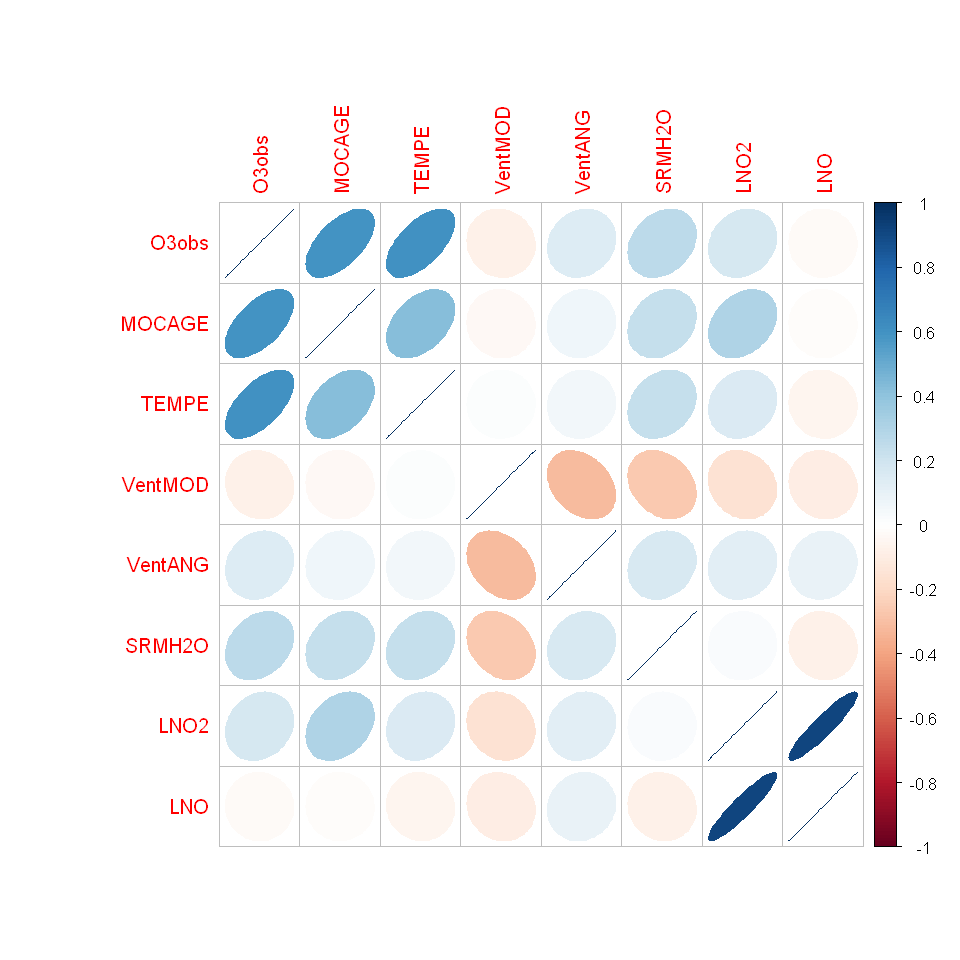

In [10]:
library(corrplot)

M <- cor(ozone[, c(2:4, 6:10)])
corrplot(M, method="ellipse")

Les commandes suivantes permettent de réaliser une [analyse en composantes principales](http://wikistat.fr/pdf/st-m-explo-acp.pdf) sur les seules variables quantitatives. Par ailleurs la variable à modéliser  (O3obs, concentration observée) n'est pas utilisée.

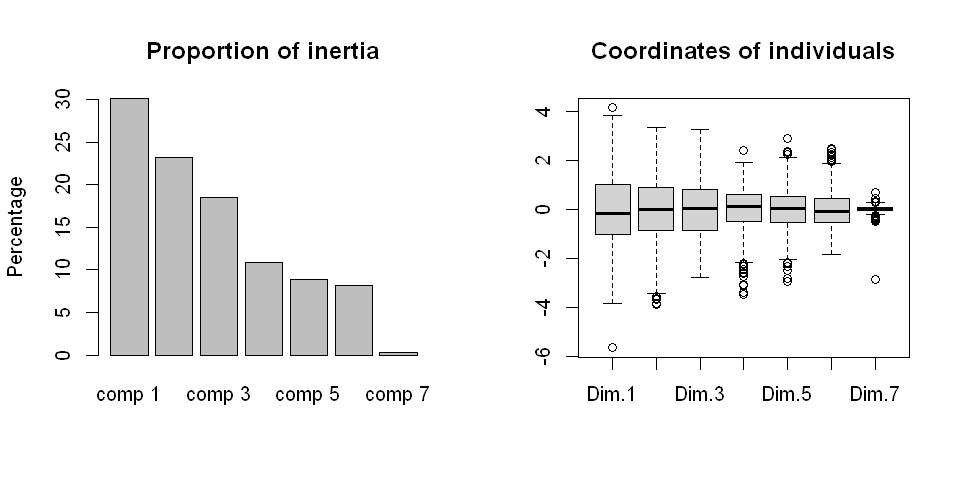

In [11]:
# ACP réduite
# Décroissance des valeurs propres
library(FactoMineR)
acp <- PCA(ozone[, c(11,2:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, quanti.sup = 2, ncp = 7)
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
barplot(acp$eig[, 2], ylab = "Percentage", main = "Proportion of inertia")
boxplot(acp$ind$coord, main = "Coordinates of individuals")

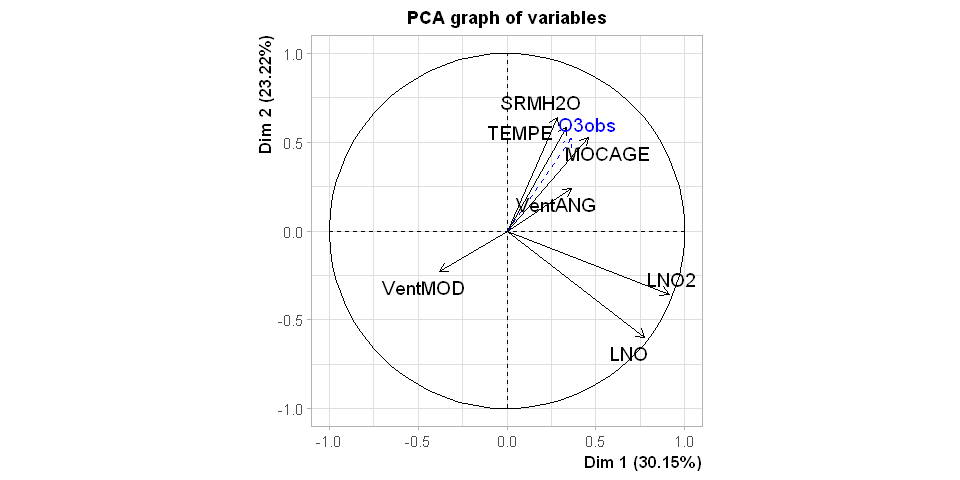

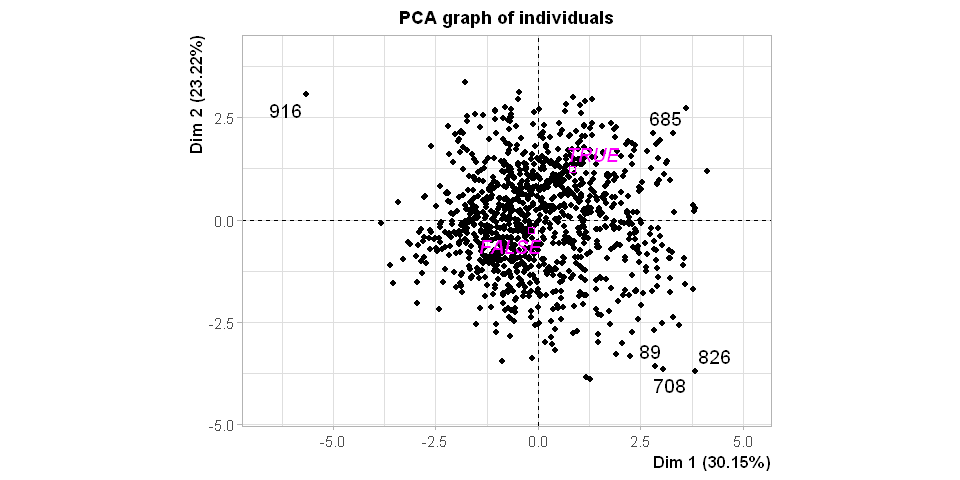

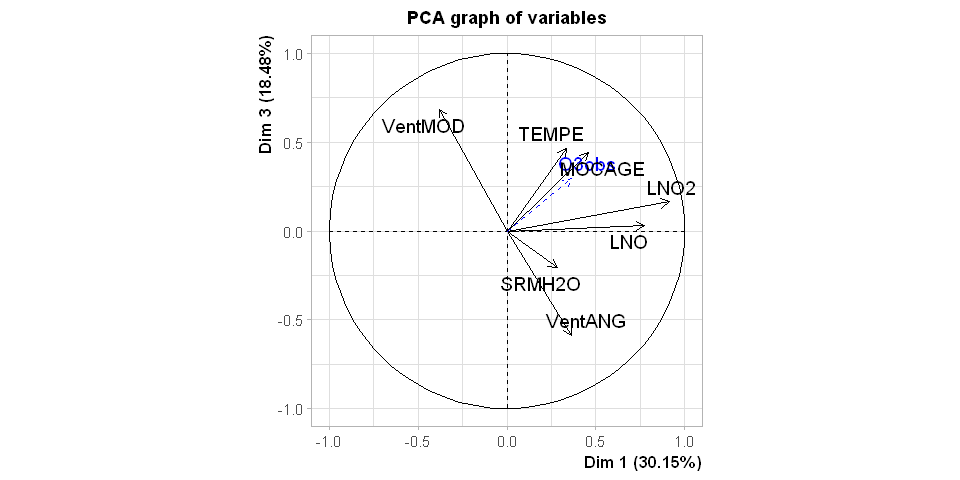

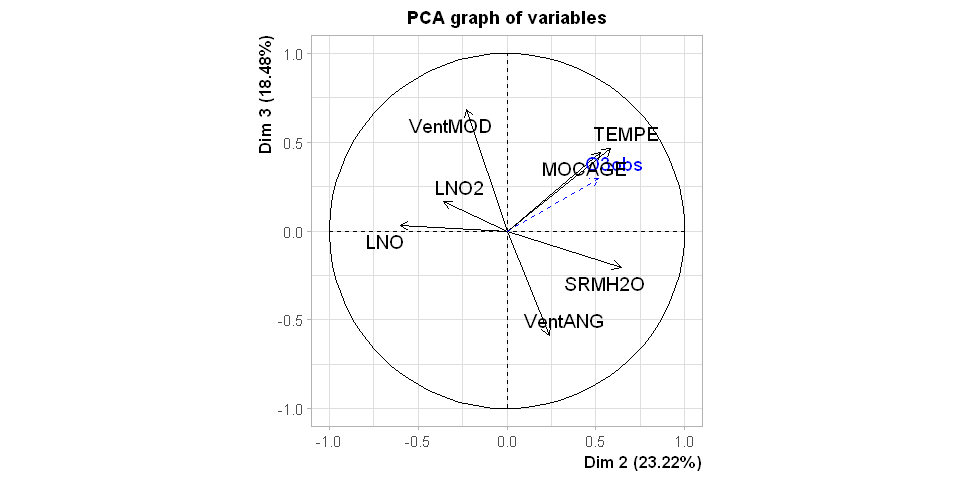

In [12]:
plot(acp, choix = "varcor")
plot(acp, choix = "ind", select = "contrib 5", unselect = 0)
plot(acp, choix = "varcor", axes=c(1, 3))
plot(acp, choix = "varcor", axes=c(2, 3))

**Q** Que sont ces graphiques?

Le barplot représente le pourcentage de variance expliquée par chacune des composantes principales. Le boxplot représente la même chose mais avec plus d'informations (médiane, outliers...).
<br>
Les deux graphiques suivants représentent les variables et les individus respectivement. On peut voir que les variables du haut sont portées surtout par la deuxième variable explicative, celles d'en bas à droite par la première composante.
On remarque que la variable `VentMOD` est contrastée par rapport aux autres.
<br>
Les individus sont très centrés sauf pour le $916$.

**Q** Que dire du choix de la dimension, des valeurs atypiques?

Il se peut qu'il y ait des valeurs erronnées.

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO,DepSeuil
,<fct>,<int>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
912,1,146,135.1,24.8,Pla,6.1008,1.55440,0.12275993,-0.7423374,-2.4769385,FALSE
913,1,95,129.0,23.4,Pla,5.9008,1.55385,0.14408331,-1.1425642,-2.9565116,FALSE
914,0,115,112.5,24.1,Pla,5.9808,0.35877,0.12012493,0.6402737,-0.8964881,FALSE
915,0,141,144.7,26.4,Pla,10.1833,-0.12801,0.13187115,1.2598804,-0.4926583,FALSE
916,1,166,173.5,18.2,Pla,5.7706,-1.08390,0.08093207,-1.1147417,-6.9077553,TRUE
917,0,128,165.0,18.8,Pla,7.4095,-1.01649,0.07252586,0.4574248,-1.4188176,FALSE
918,0,103,123.5,17.1,Pla,12.2037,-0.58118,0.06324555,1.1252542,-0.3609699,FALSE
919,1,106,151.3,14.7,Pla,15.5878,-0.72185,0.07362065,-0.0629398,-1.7259717,FALSE
920,0,114,144.5,15.9,Pla,10.3788,-0.43779,0.06074537,1.9599539,0.4041309,FALSE


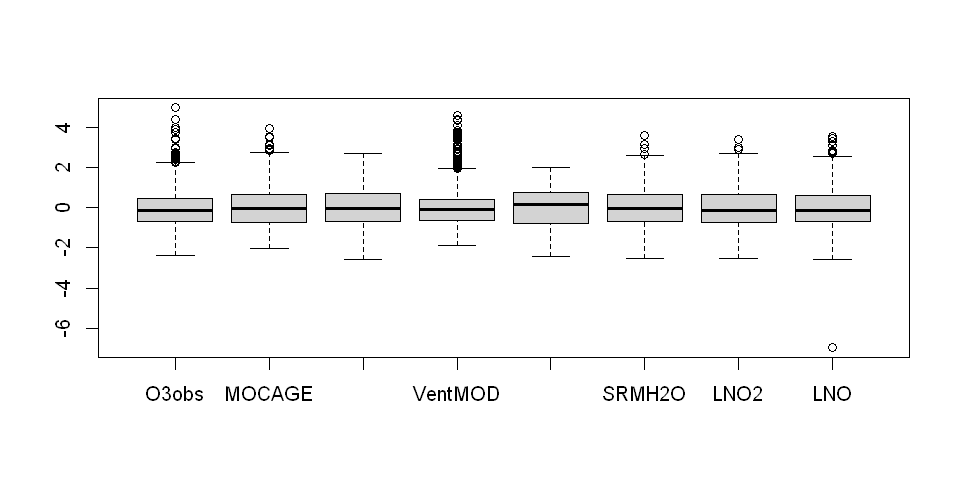

In [13]:
ozone[912:920,]
boxplot(scale(ozone[, c(2:4, 6:10)]))

**Q** Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

Même graphe en coloriant les dépassements de seuil.

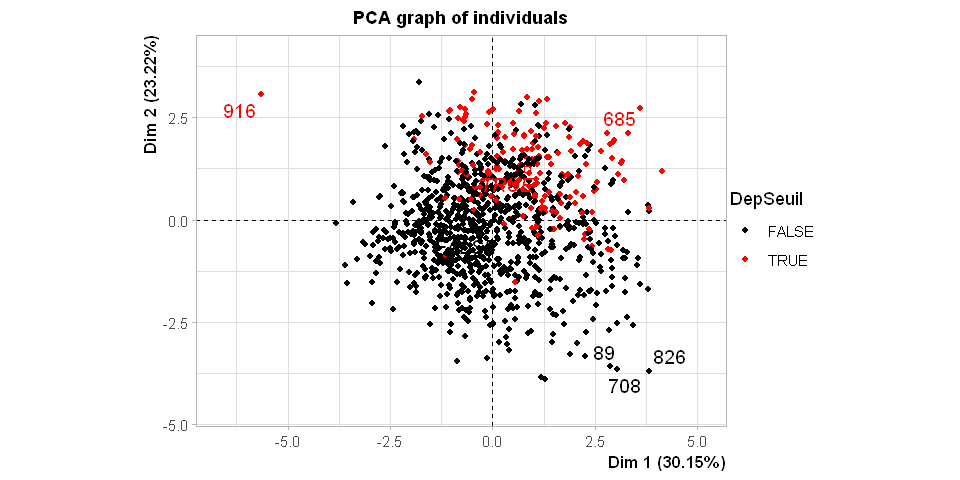

In [14]:
plot(acp, choix = "ind", habillage = 1,
     select = "contrib 5", unselect = 0)

L'objectif est donc de définir une surface séparant les deux classes. 

**Q** Une discrimination linéaire (hyperplan) semble-t-elle possible? 

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme k-means. Donne t-elle la même information ?

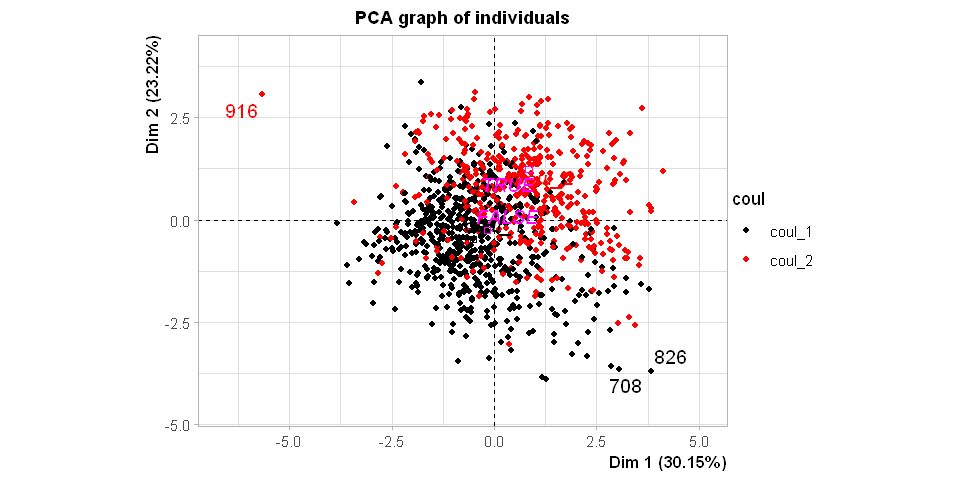

In [15]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(coul = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
plot(acp2, choix = "ind", habillage = "coul",
     select = "contrib 3", unselect = 0)

In [48]:
table(km.ozone$cluster, ozone$DepSeuil)

   
    FALSE TRUE
  1   589   31
  2   274  147

## Protocole de comparaison

### Stratégie

La recherche  d'une meilleure méthode de prévision suit le protocole suivant.

1. Étape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou *features* spécifiques des données. 
2. Procéder à un tirage aléatoire d'un échantillon *test* qui ne sera utilisé que lors de la *dernière étape* de comparaison des méthodes.
3. La partie restante est l'échantillon d'*apprentissage* pour l'estimation des paramètres des modèles.
4. Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par [*validation croisée*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf):
    - Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
    - variables et méthode pour l'analyse discriminante;
    - nombre de feuilles dans l'arbre de régression ou de classification;
    - architecture (nombre de neurones, pénalisation) du perceptron;
    - algorithme d'agrégation, 
    - noyau et pénalisation des SVMs.
5.  Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

**Remarques**
* En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

**Q** Commenta appelle-t-on cette procédure spécifique de validation croisée?

* *Attention*: ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!
* Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, *log loss function*...

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test. 

Utiliser trois chiffres au hasard, et **remplacer** "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats.

In [16]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [17]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11] 
# construction de l'échantillon test
datestr <- ozone[testi, -11] 
# vérification
str(datappr)
str(datestr)
#summary(datappr) 

'data.frame':	832 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ O3obs  : int  91 100 82 94 107 150 164 135 121 129 ...
 $ MOCAGE : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE  : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD: num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG: num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2   : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO    : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR   : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ O3obs  : int  135 143 71 77 79 155 101 75 114 156 ...
 $ MOCAGE : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE  : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION: Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD: num  2.1 3.14 10

Construction des échantillons pour la discrimination: prévision de dépassement.

In [18]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2]
# construction de l'échantillon test 
datestq <- ozone[testi,-2] 

# vérification
str(datappq)
str(datestq)
#summary(datappq)

'data.frame':	832 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 2 2 1 1 1 1 1 2 2 1 ...
 $ MOCAGE  : num  93.2 104.6 103.6 94.8 99 ...
 $ TEMPE   : num  21.5 20.2 17.4 18.8 23.7 23.6 26.6 23.5 23.3 23.7 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ VentMOD : num  9.5 8.01 9.38 9.46 7.88 ...
 $ VentANG : num  -0.643 -0.05 -0.128 -0.345 -0.418 ...
 $ SRMH2O  : num  0.092 0.0939 0.0975 0.0925 0.0855 ...
 $ LNO2    : num  0.471 0.752 0.505 0.854 0.503 ...
 $ LNO     : num  -0.858 -0.633 -0.761 -0.355 -0.794 ...
 $ DepSeuil: Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 1 1 2 1 1 1 ...
'data.frame':	209 obs. of  10 variables:
 $ JOUR    : Factor w/ 2 levels "0","1": 1 1 1 2 1 1 1 2 2 2 ...
 $ MOCAGE  : num  127.8 189.7 103.9 73 87.8 ...
 $ TEMPE   : num  18.8 21 25.9 23.5 12.3 32.2 19.4 27.6 24.9 27 ...
 $ STATION : Factor w/ 5 levels "Aix","Als","Cad",..: 3 4 1 5 5 1 2 3 4 2 ...
 $ VentMOD : num  2.1 3.14 10.68 4.3 4.6 ...
 $ VentANG : 

Enfin, avant de passer aux différents algorithmes, définissons une fonction traçant le graphe des résidus avec des couleurs et des échelles fixes sur les axes. 

In [19]:
options(repr.plot.width = 8, repr.plot.height = 4)
# Définition d'une fonction pour un graphe coloré et des échelles fixes sur les
# axes
plot.res <- function(x, y, titre = "titre") {
    plot(x, y, col = "blue", xlim = c(0, 250), ylim = c(-100, 100), ylab = "Résidus", 
        xlab = "Valeurs prédites", main = titre, pch = 20)
    # points(x2, y, col='red')
    abline(h = 0, col = "green")
}

## [Prévision par modèle gaussien](http://wikistat.fr/pdf/st-m-app-select.pdf)

Le premier modèle à tester est un simple modèle de régression linéaire mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

### Modèle linéaire

#### Sans sélection de variables

Le modèle de régression linéaire simple intégre des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

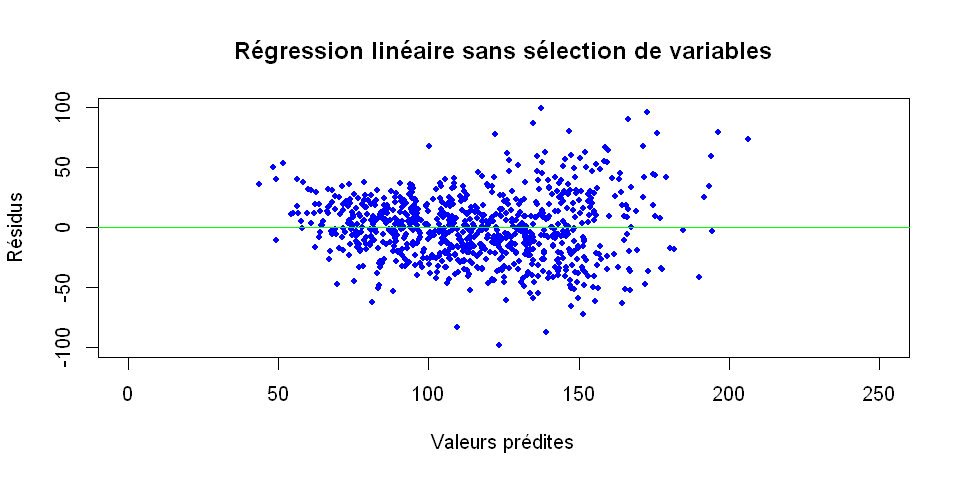

In [20]:
# estimation du modèle sans interaction
reg.lm <- aov(O3obs ~ . , data = datappr)

# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Graphe des résidus. 
plot.res(fit.lm,res.lm,"Régression linéaire sans sélection de variables")

**Q** Que dire de la distribution de ces résidus? 

**Q** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle?

Apprécier néanmoins sa significativité par la commande suivante.

In [21]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    106     106   0.134 0.714791    
MOCAGE        1 470173  470173 590.680  < 2e-16 ***
TEMPE         1 225427  225427 283.204  < 2e-16 ***
STATION       4  10163    2541   3.192 0.012926 *  
VentMOD       1  13846   13846  17.395 3.36e-05 ***
VentANG       1  10088   10088  12.673 0.000392 ***
SRMH2O        1    273     273   0.343 0.558101    
LNO2          1   3337    3337   4.193 0.040918 *  
LNO           1   9006    9006  11.314 0.000805 ***
Residuals   819 651913     796                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

**Q** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

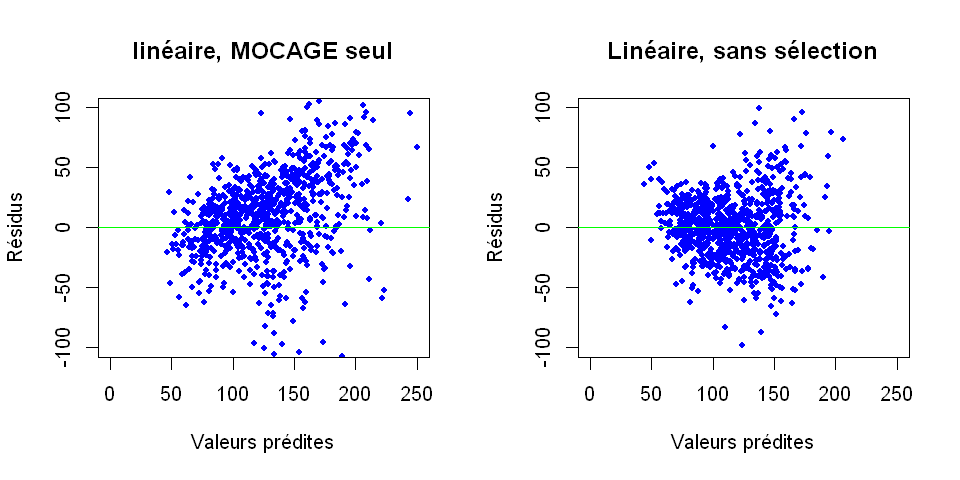

In [22]:
# Graphe des résidus du modèle déterministe MOCAGE
par(mfrow = c(1, 2))
plot.res(datappr[, "MOCAGE"],
         datappr[, "MOCAGE"] - datappr[, "O3obs"], "linéaire, MOCAGE seul")
plot.res(fit.lm, res.lm, "Linéaire, sans sélection")
par(mfrow = c(1, 1))

#### Sélection de variable par régularisation L1 (LASSO)

Loading required package: Matrix

Loaded glmnet 4.1



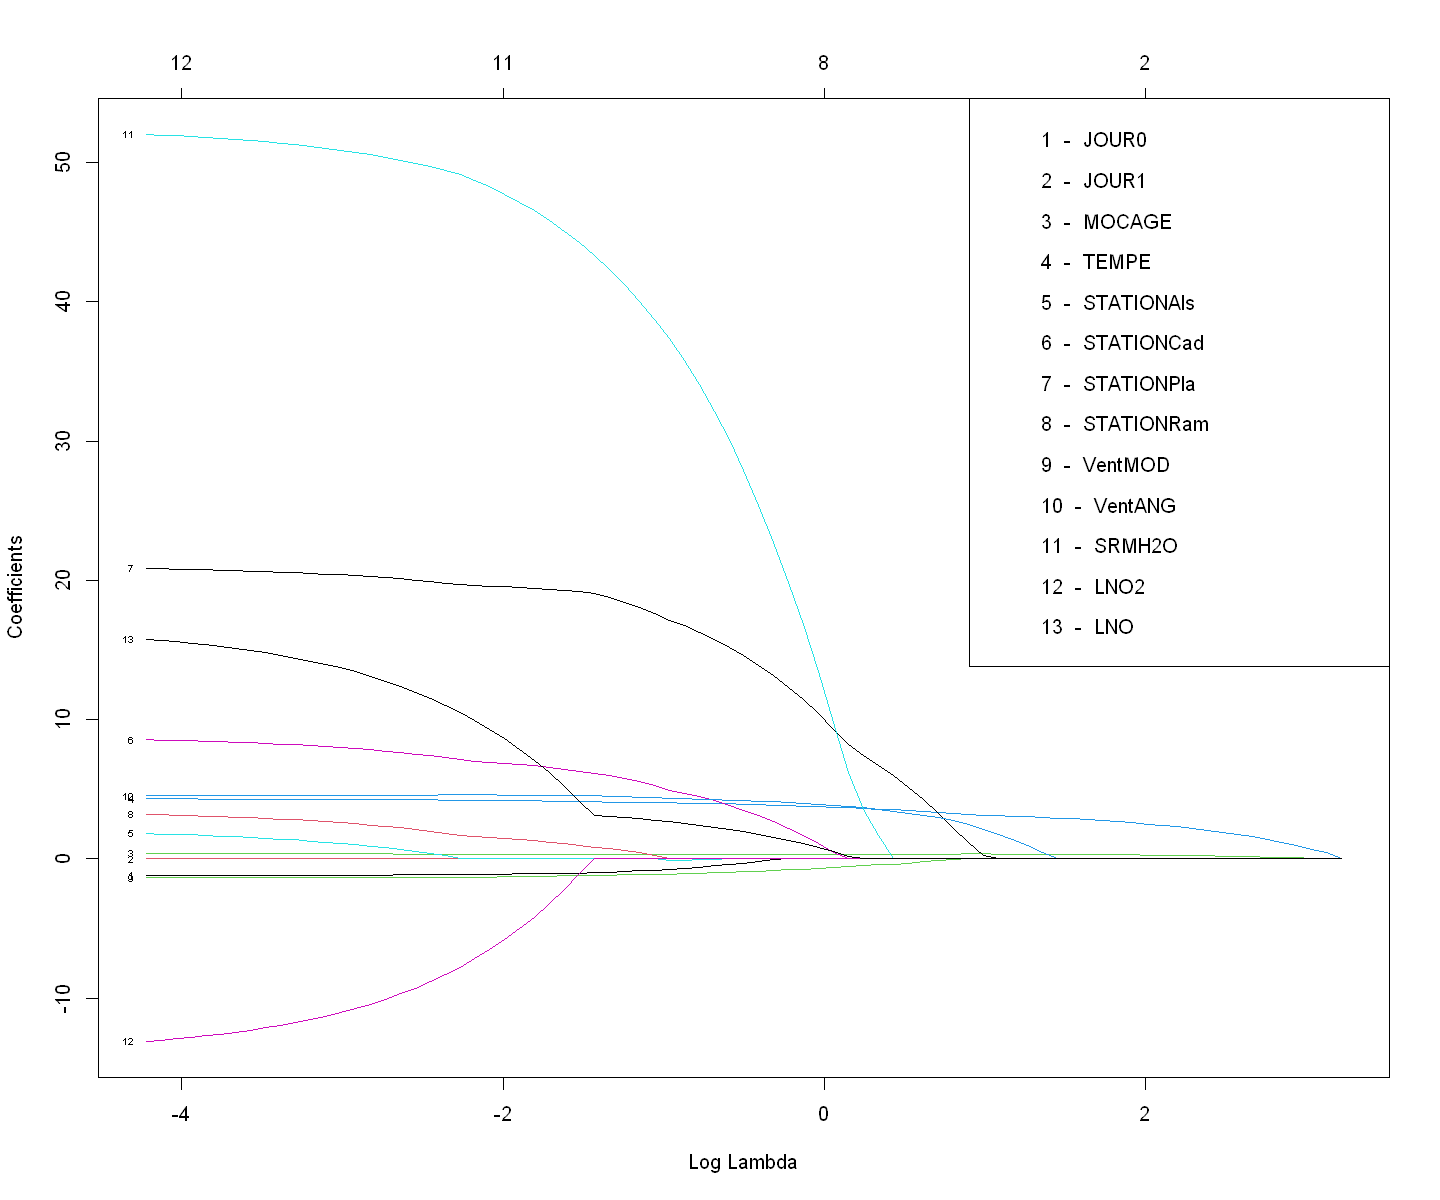

In [23]:
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

**Q** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

**Q** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?

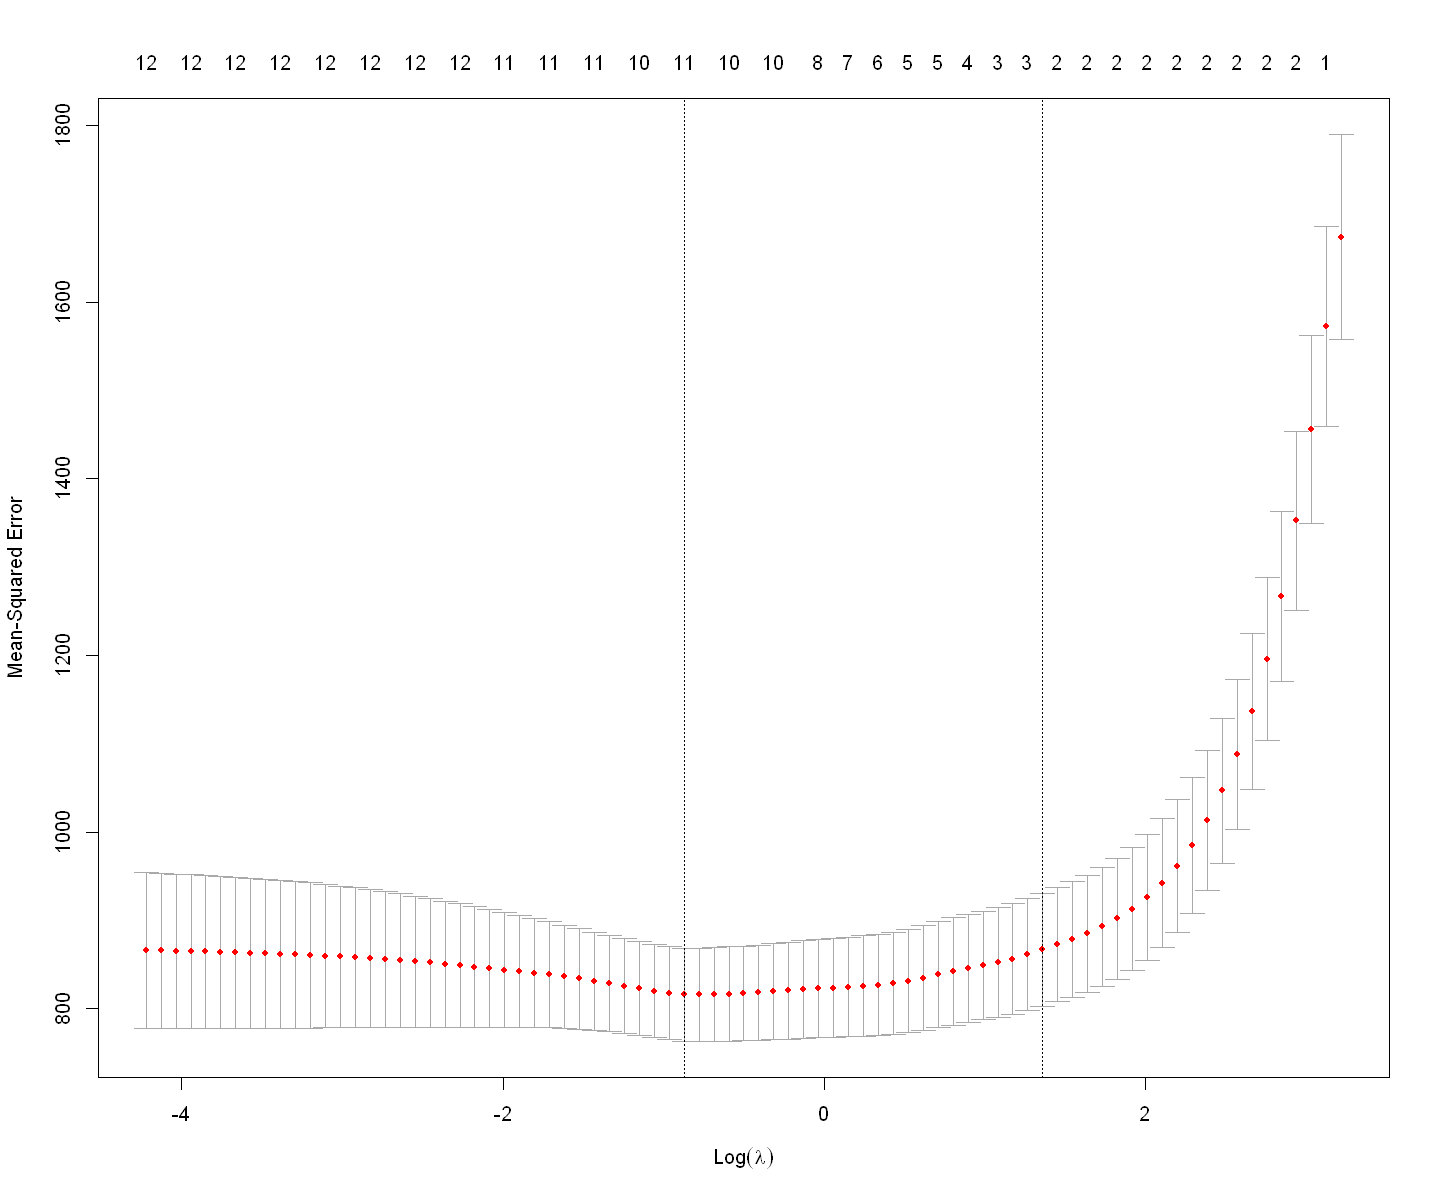

In [24]:
# choix du paramètre de régularisation par validation croisée
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
plot(reg.lasso.cv)

**Q** Que représente la courbe rouge ? Et la bande qui est autour ? 

**Q** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?

In [25]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 3.896"

14 x 1 sparse Matrix of class "dgCMatrix"
                    1
(Intercept) 1.1658431
JOUR0       .        
JOUR1       .        
MOCAGE      0.3370194
TEMPE       2.9855716
STATIONAls  .        
STATIONCad  .        
STATIONPla  .        
STATIONRam  .        
VentMOD     .        
VentANG     0.4939696
SRMH2O      .        
LNO2        .        
LNO         .        

**Q** Combien restent-ils de coefficients non nuls. Vérifier sur les chemins de régularisation.

**Q** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. "reg.lasso.cv$lambda.min"

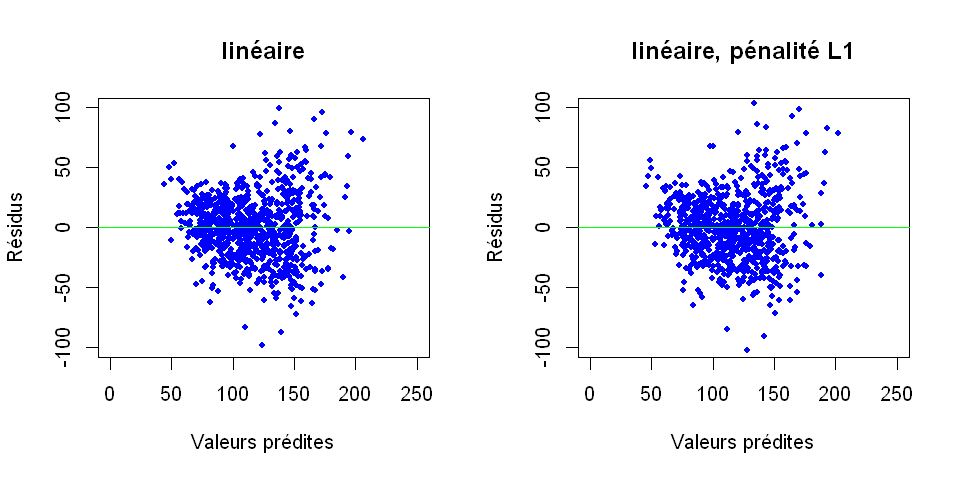

In [26]:
# Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso
# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 4)
par(mfrow = c(1, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

**Q** Commenter. 

**Q** Calculer le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

**Q** Estimer l'erreur de généralisation du modèle de régression linéaire simple sans sélection de variables par validation croisée. Comparer avec celle du LASSO. Qu'observez-vous?

### Modèle quadratique

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction glm qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC ou *Akaïke Information Criterion*. 

**Q** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisée en régression linéaire? 


In [27]:
# Estimation du modèle de toute interaction d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7783.44
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- JOUR:STATION     4   471877 7776.5
- STATION:VentANG  4   471970 7776.7
- JOUR:TEMPE       1   471262 7781.4
- JOUR:LNO2        1   471262 7781.4
- LNO2:LNO         1   471263 7781.4
- JOUR:SRMH2O      1   471265 7781.4
- MOCAGE:TEMPE     1   471270 7781.5
- JOUR:LNO         1   471321 7781.5
- JOUR:MOCAGE      1   471324 7781.6
- VentMOD:VentANG  1   471374 7781.6
- JOUR:VentANG     1   471464 7781.8
- MOCAGE:VentANG   1   471510 7781.9
- MOCAGE:STATION   4   475115 7782.2
- JOUR:VentMOD     1   471774 7782.3
- VentANG:SRMH2O   1   471804 7782.4
- MOCAGE:SRMH2O    1   471846 7782.5
- VentMOD:LNO2     1   472012 7782.8
- TEMPE:VentMOD    1   472318 7783.3
<none>                 471261 7783.4
- VentMOD:LNO      1   472416 7783.5
- MOCAGE:VentMOD   1   472452 7783.5
- STATION:LNO      4   476488 7784.6
- VentANG:LNO2     1   473094 7784.7


In [28]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,831,1394332.0,NA,NA
MOCAGE,1,469071.2081,830,925260.8,763.8571548,3.647061e-118
TEMPE,1,225512.0241,829,699748.7,367.2341644,1.630666e-67
STATION,4,10252.6125,825,689496.1,4.1739566,2.371040e-03
VentMOD,1,14316.7164,824,675179.4,23.3140002,1.652264e-06
VentANG,1,10355.9415,823,664823.5,16.8640919,4.433664e-05
SRMH2O,1,244.5782,822,664578.9,0.3982825,5.281601e-01
LNO2,1,3273.0334,821,661305.9,5.3299583,2.121919e-02
LNO,1,9138.5263,820,652167.3,14.8815971,1.238032e-04


#### Sélection de variable par régularisation L1 (LASSO)

In [29]:
# Comparer avec un modèle quadratique avec pénalité L1
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                              1
(Intercept)         29.78872739
JOUR0                .         
JOUR1                .         
MOCAGE               .         
TEMPE                1.26885748
STATIONAls           .         
STATIONCad           .         
STATIONPla           .         
STATIONRam           .         
VentMOD              .         
VentANG              .         
SRMH2O               .         
LNO2                 .         
LNO                  .         
JOUR1:MOCAGE         .         
JOUR1:TEMPE          .         
JOUR1:STATIONAls     .         
JOUR1:STATIONCad     .         
JOUR1:STATIONPla     .         
JOUR1:STATIONRam     .         
JOUR1:VentMOD        .         
JOUR1:VentANG        .         
JOUR1:SRMH2O         .         
JOUR1:LNO2           .         
JOUR1:LNO            .         
MOCAGE:TEMPE         0.01332892
MOCAGE:STATIONAls    .         
MOCAGE:STATIONCad    .         
MOCAGE:STATIONPla    .        

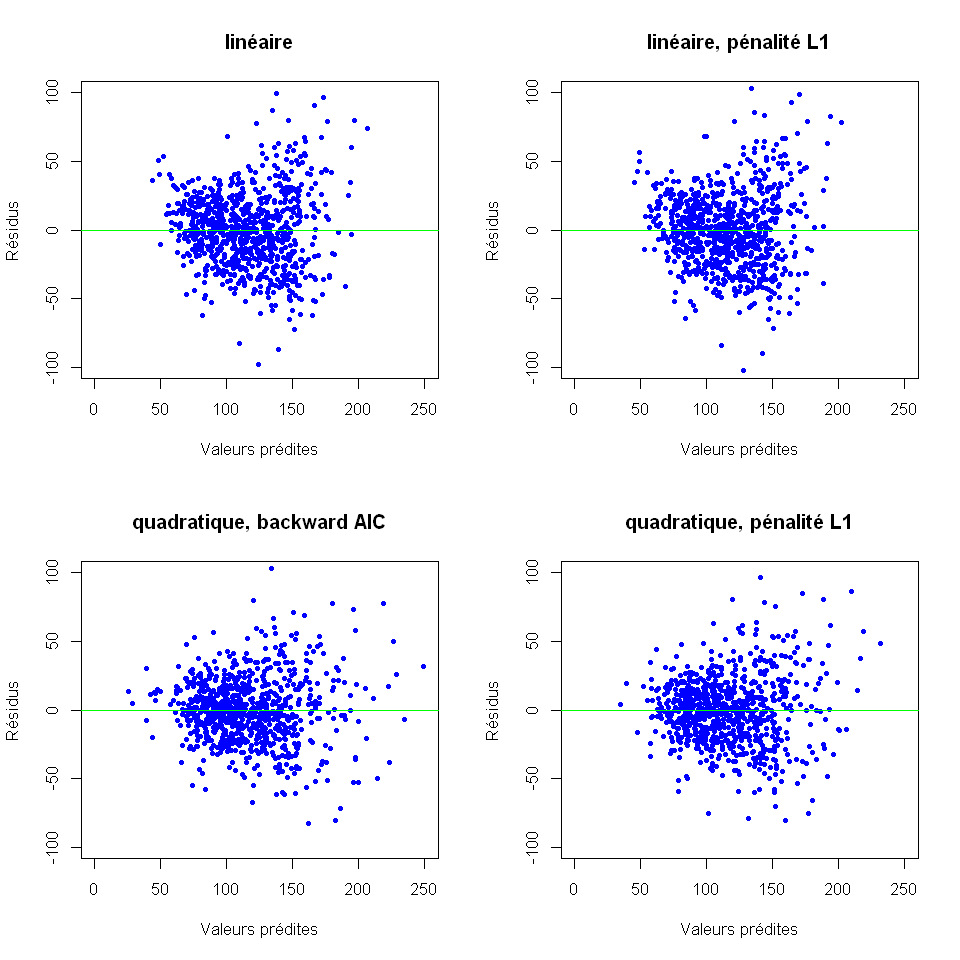

In [30]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2

# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(2, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
plot.res(fit.glm, res.glm, "quadratique, backward AIC")
plot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")

 On remarque que la présence de certains interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.
 
Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.

### Prévision de l'échantillon test

Le modèle "optimal" obtenu par la méthode stepwise est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées ; la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés. 

#### Erreur de régression

In [31]:
# Calcul des prévisions pour le nomdèle quadratique backward AIC
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 601.5874

In [32]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1384.503

#### Erreur de classification (matrice de confusion)

In [33]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   161   19
  TRUE      5   24

In [34]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   141   19
  TRUE     25   24

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

## [Prévision par modèle binomial](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.

### Régression logistique sans interaction

In [35]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significativité des paramètres
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
JOUR,1,0.4443555,830,737.3698,5.050277e-01
MOCAGE,1,125.2166123,829,612.1532,4.563158e-29
TEMPE,1,136.8421803,828,475.3110,1.305601e-31
STATION,4,16.9891229,824,458.3219,1.942378e-03
VentMOD,1,11.7860664,823,446.5358,5.967570e-04
VentANG,1,0.8373860,822,445.6984,3.601454e-01
SRMH2O,1,6.4120067,821,439.2864,1.133512e-02
LNO2,1,0.1893011,820,439.0971,6.634989e-01


In [36]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=459.72
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   434.25 458.25
- JOUR     1   434.36 458.36
- VentANG  1   434.60 458.60
<none>         433.72 459.72
- LNO      1   439.10 463.10
- LNO2     1   439.21 463.21
- SRMH2O   1   440.49 464.49
- VentMOD  1   440.90 464.90
- STATION  4   455.47 473.47
- TEMPE    1   550.99 574.99

Step:  AIC=458.25
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   434.79 456.79
- VentANG  1   435.23 457.23
<none>         434.25 458.25
- SRMH2O   1   441.49 463.49
- VentMOD  1   442.86 464.86
- LNO      1   447.00 469.00
- LNO2     1   451.13 473.13
- STATION  4   471.33 487.33
- TEMPE    1   558.59 580.59

Step:  AIC=456.79
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
- VentANG  1   436.01 456.01
<none>         434.79 456.79

In [37]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
STATION,4,32.315989,826,491.3091,1.648689e-06
VentMOD,1,29.015384,825,462.2937,7.180577e-08
SRMH2O,1,9.116772,824,453.1770,2.532764e-03
LNO2,1,5.017192,823,448.1598,2.509684e-02
LNO,1,12.150777,822,436.0090,4.906743e-04


In [38]:
# matrice de confusion de l'échantillon d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   673   70
  TRUE     24   65

### Régression logistique avec interactions

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique  rencontre des soucis et affiche des *warnings* car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure *forward* ou  mieux *stepwise* de sélection des variables et interactions  conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [39]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

Start:  AIC=739.81
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   523.63 527.63
+ MOCAGE   1   613.24 617.24
+ SRMH2O   1   683.87 687.87
+ VentANG  1   726.72 730.72
+ STATION  4   721.68 731.68
+ LNO2     1   727.76 731.76
+ VentMOD  1   733.38 737.38
<none>         737.81 739.81
+ LNO      1   736.47 740.47
+ JOUR     1   737.37 741.37

Step:  AIC=527.63
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   476.67 482.67
+ STATION  4   491.31 503.31
+ SRMH2O   1   503.12 509.12
+ VentMOD  1   515.31 521.31
+ VentANG  1   516.54 522.54
<none>         523.63 527.63
+ LNO      1   521.92 527.92
+ JOUR     1   522.78 528.78
+ LNO2     1   523.06 529.06
- TEMPE    1   737.81 739.81

Step:  AIC=482.67
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   465.50 473.50
+ STATION       4   460.11 474.11
+ LNO           1   470.23 478.23
+ LNO2          1   471.61 479.61
+ VentMOD       1   473.42 481.42
+ VentANG       1   473.55 481.55
<none>  

In [40]:
anova(log.qm.step1, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
MOCAGE,1,46.956415,829,476.6687,7.258302e-12
SRMH2O,1,11.172483,828,465.4962,8.301945e-04
STATION,4,15.922320,824,449.5739,3.125190e-03
VentMOD,1,8.683311,823,440.8906,3.211370e-03
TEMPE:STATION,4,11.682335,819,429.2083,1.987666e-02
MOCAGE:VentMOD,1,5.702069,818,423.5062,1.694493e-02
SRMH2O:STATION,4,15.218744,814,408.2874,4.268380e-03


### Prévision de l'échantillon test

#### Matrice de confusion

In [41]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   164   20
  TRUE      2   23

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

#### [Courbe ROC](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)

Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

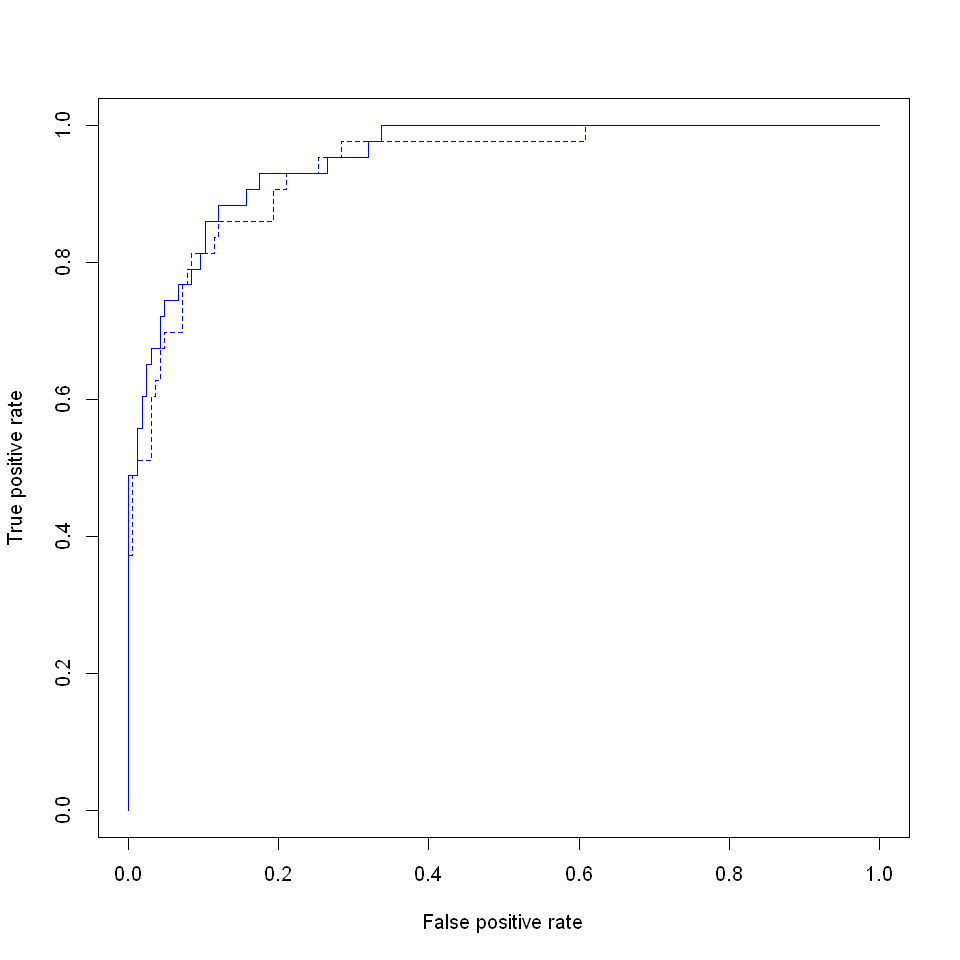

In [42]:
library(ROCR)   # Librairie à charger
roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")
# Tracé de la courbe
plot(perflogit, col = "blue")

# Calculs pour la régression
rocglm <- pred.glm / 300
predglm <- prediction(rocglm, datestq[, "DepSeuil"])
perfglm <- performance(predglm, "tpr", "fpr")
# tracé de la courbe et ajout au graphe précédent.
plot(perfglm, col = "blue",lty=2, add = TRUE)

**Q** Que sont sensibilité et spécificité d'une courbe ROC?

Les résultats obtenus dépendent évidemment en plus de l'échantillonnage initial entre apprentissage et test. Dans le cas où les courbes se croisent, cela signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle. Ceci souligne l'importance de la bonne définition du critère à utiliser pour le choix d'une "meilleure" méthode. Ce choix dépend directement de celui , "politique" ou "économique" de sensibilité et / ou spécificité du modèle retenu. En d'autres termes, quel taux de fausse alerte, avec des imputations économiques évidentes, est supportable au regard des dépassements non détectés et donc de la dégradation sanitaire de la population à risque ?
 
C'est une fois ce choix arrêté que le statisticien peut opérer une comparaison des méthodes en présence.

**Q** Les performances des deux approches gaussiennes et binomiales sont-elles très différentes?

**Q** Sur le graphe ci-dessus, ajouter la courbe ROC pour le modèle déterministe MOCAGE. Qu'observez-vous?

# <FONT COLOR="Red">Épisode 2</font>

## [Analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf)

### Introduction

 L'objectif est de comparer les trois méthodes d'analyses discriminantes disponibles dans R: `lda` paramétrique linéaire (homoscédasticité), `qda` paramétrique quadratique (hétéroscédasticité) sous hypothèse gaussienne et celle non-paramétrique des $k$ plus proches voisins.
 
**Q** Quel critère d'affectation est utilisé en `lda`?

**Q** Que signifient les hypothèses d'homo ou d'hétéroscédasticité?

**Q** Quelle fonction est estimée "non paramétriquement" par l'algorithme des $k$ plus proches voisins?
 
*Attention*, ces techniques n'acceptent par principe que des variables explicatives ou prédictives quantitatives. Néanmoins, une variable qualitative à deux modalités, par exemple le type de jour, peut être considérée comme quantitative sous la forme d'une fonction indicatrice prenant ses valeurs dans $\{0, 1\}$ et, de façon plus "abusive", une variable ordinale est considérée comme "réelle". Dans ce dernier cas, il ne faut pas tenter d'interpréter les fonctions de discrimination, juste considérer des erreurs de prévision. La variable *Station* n'est pas prise en compte.

La bibliothèque standard de R (`MASS`) pour l'analyse discriminante ne propose pas de procédure automatique de choix de variable mais, dans cet exemple, les variables sont peu nombreuses.

### Estimation des modèles

In [43]:
library(MASS) # chargement des librairies
library(class) # pour kNN

In [44]:
# analyse discriminante linéaire
disc.lda=lda(DepSeuil~.,data=datappq[,-4]) 
# analyse discriminante quadratique 
disc.qda=qda(DepSeuil~.,data=datappq[,-4]) 
# k plus proches voisins
disc.knn=knn(datappq[,c(-4,-10)],datappq[,c(-4,-10)],datappq$DepSeuil,k=10) 

Noter le manque d'homogénéité des commandes de R issues de librairies différentes. L'indice de colonne négatif ($-10$) permet de retirer la colonne contenant la variable à prédire de type facteur. Celle-ci est mentionnée en troisième paramètre pour les données d'apprentissage. La librairie [caret](http://topepo.github.io/caret/index.html) contourne ces difficultés en englobant toutes les librairies d'apprentissage et en homogénéisant les appels pour l'estimation et la prévision des modèles. 

### Estimation de l'erreur de prévision par validation croisée

In [45]:
# erreur par validation croisée  en analyse discriminante linéaire
disc.lda=lda(DepSeuil~.,data=datappq[,-4],CV=T) 
# estimer le taux d'erreur à partir de la matrice de confusion
table(datappq[,"DepSeuil"],disc.lda$class) 

       
        FALSE TRUE
  FALSE   673   24
  TRUE     77   58

In [46]:
# analyse discriminante quadratique
disc.qda=qda(DepSeuil~.,data=datappq[,-4],CV=T)  
table(datappq[,"DepSeuil"],disc.qda$class) 

       
        FALSE TRUE
  FALSE   665   32
  TRUE     78   57

Pour knn, le choix du nombre de voisins $k$ doit être optimisé par validation croisée mais la procédure proposée par la bibliothèque `class` est celle *leave-one-out*, donc trop coûteuse en calcul pour des gros fichiers. Il serait simple de la programmer mais une autre bibliothèque (`e1071`) propose déjà une batterie de fonctions de validation croisée pour de nombreuses techniques de discrimination. 

In [47]:
# k plus proches voisins: optimisation de k
library(e1071)
plot(tune.knn(as.matrix(datappq[,c(-4,-10)]),as.factor(datappq[,10]),k=2:20))

ERROR: Error in library(e1071): there is no package called 'e1071'


**Q** Quelle procédure de validation croisée est exécutée par défaut par la fonction `tune`?

Lancer plusieurs exécutions successives de cette "optimisation".

**Q** Pourquoi la valeur de $k$ optimale diffère à chaque exécution? Comment choisir k ? 

Comparer avec les erreurs précédentes estimées également par validation croisée. 

**Q** Quelle analyse discriminante retenir ? Pourquoi?

### Prévision de l'échantillon test

#### Matices de confusion

Les commandes suivantes calculent la matrice de confusion pour la "meilleure" méthode d'analyse discriminante au sens de la validation croisée. Cette "meilleure" méthode peut être edifférente d'un participant à l'autre.

In [ ]:
disc.lda=lda(DepSeuil~.,data=datappq[,-4])  
table(predict(disc.lda,datestq[,-4])$class,datestq[,"DepSeuil"])

A titre indicatif, voici l'estimation de l'erreur sur l'échantillon test pour la méthode des $k$ plus proches voisins.

In [ ]:
disc.knn=knn(as.matrix(datappq[,c(-4,-10)]),as.matrix(datestq[,c(-4,-10)]),datappq$DepSeuil,k=15)
table(disc.knn,datestq$DepSeuil)

#### Courbes ROC

In [ ]:
library(ROCR)
ROCdiscrim=predict(disc.lda,datestq[,c(-4)])$posterior[,2]
preddiscrim=prediction(ROCdiscrim,datestq$DepSeuil)
perfdiscrim=performance(preddiscrim,"tpr","fpr")
# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue") 
plot(perfdiscrim,col="magenta",add=TRUE)  

**Q** Une méthode est-elle uniformément meilleure sur cet échantillon test ?

## [Arbre de décision binaire](http://wikistat.fr/pdf/st-m-app-cart.pdf)

La librairie  `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbre peuvent être estimer selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres  contrôlent l'exécution de l'algorithme: la pénalisation  minimale (`cp`) pour la construction de l'arbre maximal, le nombre minimal d'observation par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (?rpart.control) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres, c'est le travers des logiciels "libres".

**NB.** Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.


### Estimation et élagage de l'arbre de régression
**Q** Quel critère est optimisé lors de la création d'un noeud? de l'arbre?

In [ ]:
library(rpart) # chargement de la librairie
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu
# summary(tree.reg)  
# mais un graphe est  préférable

In [ ]:
plot(tree.reg)
text(tree.reg)

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par  validation croisée *10-fold* pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`. 

In [ ]:
xmat=xpred.rpart(tree.reg)
xerr=(xmat-datappr[,"O3obs"])^2
CVerr=apply(xerr,2,sum)
CVerr  #    CP           erreur

Chercher la valeur de `cp` correspondant à la plus petite erreur puis l'utiliser la construction del'arbre.

In [ ]:
as.numeric(attributes(which.min(CVerr))$names)

In [ ]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

La librairie `partykit` propose une construction graphique de l'arbre:

In [ ]:
library(partykit)
plot(as.party(tree.reg), type="simple")

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille. 

**Q** Quelle est la variable qui contribue le plus à l'interprétation?

Graphe des résidus

In [ ]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
plot.res(fit.tree,res.tree)

**Q** A quoi est due la structure particulière de ce graphe?

### Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités *a priori* (?rpart pour plus de détails).

**Q** Quel autre critère d'hétérogénéité est utilisé?

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
plot(tree.dis) 
text(tree.dis)  

La même procédure d'élagage par validation croisée est mise en place mais avec un expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [ ]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

In [ ]:
as.numeric(attributes(which.min(CVerr))$names)

In [ ]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),
               cp=as.numeric(attributes(which.min(CVerr))$names))
plot(as.party(tree.dis), type="simple")

### Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 

#### Erreur de régression

In [ ]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr)
pred.treeq=predict(tree.dis,newdata=datestq,type="class") 
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

#### Erreur de classification (matrice de confusion)

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.treer>150,datestr[,"O3obs"]>150)

In [ ]:
# Même chose pour l'arbre de discrimination
table(pred.treeq,datestq[,"DepSeuil"])

**Q** Quelle stratégie semble meilleure à ce niveau?

#### Courbes ROC

In [ ]:
ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col="blue")
plot(perfregtree,col="orange",lty=2,add=TRUE) 
plot(perfdistree,col="orange",add=TRUE)  

Comparer les qualités  de prévision.

**Q** Une meilleure méthode se dégage-t-elle?

# <FONT COLOR="Red">Épisode 3</font>

## [Réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf)

### Introduction

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence. 

**Q** Quelle fonction de transfert pour le dernier neurone en régression ?

**Q** Quelle focntion de transfert pour le dernier neuronne en discrimination binaire?

**Q** Quid de la discrimination avec plusieurs classes?

**Q** Quel est le choix par défaut pour les neurones de la couche cachée?

Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première conciste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée. 

**Q** Quel est le paramètre `decay` de la fonction `nnet`?

**Q** Indiquer une autre façon déviter le sur-apprentissage.

### Cas de la régression

In [ ]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constituent pas des résultats très explicites ! Contrôler le nombre de poids estimés.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

In [ ]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

Faire éventuellement varier la grille des paramètres (zoom), noter la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Noter également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. 

In [ ]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
plot.res(fit.nnetr,res.nnetr,titre="")

### Cas de la discrimination

In [ ]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : nombre de neurones, `decay` et éventuellement le nombre max d'itérations. 

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur. 

Noter la taille et le `decay` optimaux et ré-estimer le modèle pour ces valeurs.

In [ ]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [ ]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1) 

### Prévisions de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 


#### Erreur de régression

In [ ]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq) 
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Erreur de classification (matrice de confusion)

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)

In [ ]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])

#### Courbes ROC

In [ ]:
library(ROCR)
rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")

rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")

# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col="blue")
plot(perfnnetr,col="darkgreen",lty=2,add=TRUE) 
plot(perfnnetq,col="darkgreen",add=TRUE)  

**Q** Une méthode semble-t-elle significativement meilleure?

## [Agrégation de modèles](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

### Introduction

Les sections précédentes ont permis d'expérimenter les constructions d'un modèle de prévision assorties du problème récurrent lié à l'optimisation de la complexité d'un modèle. Cette section aborde d'autres stratégies dont l'objectif est de s'affranchir de ce problème de choix, par des méthodes se montrant pas ou très peu sensibles au sur-apprentissage ; c'est le cas des algorithmes d'agrégation de modèles.

Cette section propose de mettre en évidence la plus ou moins grande influence des paramètres de ces méthodes. 
* *Random forest*: nombre d'arbres et `mtry` et intérêt des critères de Breiman permettant de mesurer l'influence des variables au sein d'une famille agrégée de modèles. 
* Le *bagging*, cas particulier de forêt aléatoire, n'est pas traité;
* *Boosting*: profondeur d'arbre, nombre d'itérations ou d'arbres et coefficient de *shrinkage*.

**Q** Quel est le paramètre `mtry` de la fonction `randomForest`?

**Q** En quoi le bagging est un cas particulier des forêts aléatoires?

### Forêts aléatoires

Le programme est disponible dans la librairie *randomForest*. Il est écrit en fortran, donc en principe efficace en terme de rapidité d'exécution, et facile à utiliser grâce à une interface avec R. La comparaison avec Python montre qu'il n'est finalement pas très efficace sans doute à cause de l'interface avec R. Les paramètres et sorties sont explicités dans l'aide en ligne.

En R et pour des gros fichiers, privilégier la librairie `ranger` à la place de `ranfomForest`. 

#### Régression

In [ ]:
library(randomForest)
rf.reg=randomForest(O3obs~., data=datappr,xtest=datestr[,-2],ytest=datestr[,"O3obs"],
   ntree=500,do.trace=50,importance=TRUE)

**Q** Quelles est la valeur par défaut de `mtry`?

Relancer en faisant varier les paramètres `mtry` et `ntree` pour expérimenter leur peu d'influence sur les erreurs.

Calcul et graphe des résidus.

In [ ]:
fit.rfr=rf.reg$predicted
res.rfr=fit.rfr-datappr[,"O3obs"]
plot.res(fit.rfr,res.rfr,titre="")

#### Discrimination
**Q** Quelle est la valeur par défaut de `mtry`?

In [ ]:
rf.dis=randomForest(DepSeuil~.,data=datappq,xtest=datestq[,-10],ytest=datestq[,
   "DepSeuil"],ntree=500,do.trace=50,importance=TRUE)

Commenter les erreurs, tester d'autres exécutions avec d'autres valeurs des paramètres.

#### Importance des variables

Le modèle obtenu est ininterprétable mais des coefficients estiment les contributions des variables dans leur participation à la discrimination. Comparer avec les variables sélectionnées par les autres modèles. deux critères d'importance sont proposés.

**Q** Quelles sont les deux mesures d'importance des variables?

In [ ]:
sort(round(importance(rf.reg), 2)[,1], decreasing=TRUE)
sort(round(importance(rf.dis), 2)[,4], decreasing=TRUE)

### Boosting

Deux librairies proposent des versions relativement  sophistiquées des algorithmes de *boosting* dans R. La librairie *boost* propose 4 approches : *adaboost, bagboost* et deux *logitboost*. Développées pour une problématique particulière : l'analyse des données d'expression génomique, elle n'est peut-être pas complètement adaptée aux données étudiées ; elles se limitent à des prédicteurs quantitatifs et peut fournir des résultats étranges. La librairie *gbm* lui est préférée ; elle offre aussi plusieurs versions dépendant de la fonction coût choisie. Une librairie plus récente `xgboost` intègre des fonctionnalités de parallélisation (pas sous Windows) et fait intervenir plusieurs autres paramètres.

La variable à prévoir doit être codée numériquement (0,1) pour cette implémentation. Le nombre d'itérations, ou nombre d'arbres, est paramétré ainsi qu'un coefficient de rétrécissement (*shrinkage*).

**Q** Comment intervient le *schrinkage* en *boosting*? 

**Q** Pour quel boosting? Ou que signifie `gbm`?

*Attention*, par défaut, ce paramètre a une valeur très faible (0.001) et il faut un nombre important d'itérations (d'arbres) pour atteindre une estimation raisonnable. La qualité est visualisée par un graphe représentant l'évolution de l'erreur d'apprentissage. D'autre part, une procédure de validation croisée est incorporée afin d'optimiser le nombre d'arbres car la version de *boosting* considérée est (légèrement) sujette au sur-apprentissage.

#### Régression

In [ ]:
class(ozone$STATION)

In [ ]:
library(gbm)
boost.reg = gbm(O3obs ~ ., data = datappr, distribution = "gaussian", n.trees = 500, 
    cv.folds = 10, n.minobsinnode = 5, shrinkage = 0.03, verbose = FALSE)
# fixer verbose à FALSE pour éviter trop de sorties
plot(boost.reg$cv.error, type = "l")

In [ ]:
# nombre optimal d'itérations par valiation croisée
best.iter=gbm.perf(boost.reg,method="cv")

On peut s'assurer de l'absence d'un phénomène de sur-apprentissage critique en calculant puis traçant l'évolution de l'erreur sur l'échantillon test en fonction du nombre d'arbre dans le modèle. L'erreur reste stable autour du nombre d'arbres sélectionné et matérialisé par la ligne verticale. 

**Q** Tester ces fonctions en faisant varier le coefficient de rétrécissement.


In [ ]:
test=numeric()
for (i in 10:500){
pred.test=predict(boost.reg,newdata=datestr,n.trees=i)
err=sum((pred.test-datestr[,"O3obs"])^2)/nrow(datestr)
test=c(test,err)}
plot(10:500,test,type="l")
abline(v=best.iter)

#### Discrimination

Attention, la variable à modéliser doit être codée $(0, 1)$ et il faut préciser un autre paramètre de distribution pour considérer le bon terme d'erreur.

In [ ]:
datappq2=datappq
datappq2[,"DepSeuil"]=as.numeric(datappq[,"DepSeuil"])-1
boost.dis=gbm(DepSeuil~.,data=datappq2,distribution="adaboost",n.trees=500, cv.folds=10,
              n.minobsinnode = 5,shrinkage=0.03,verbose=FALSE)
plot(boost.dis$cv.error,type="l")

In [ ]:
# nombre optimal d'itérations 
best.ited=gbm.perf(boost.dis,method="cv")

Comme pour la régression, il est possible de faire varier le coefficient de rétrécissement en l'associant au nombre d'arbres dans le modèle.

Calcul des résidus et graphe.

In [ ]:
fit.boostr=boost.reg$fit
res.boostr=fit.boostr-datappr[,"O3obs"]
plot.res(fit.boostr,res.boostr,titre="")

### Prévision de l'échantillon test

#### Erreur de régression

In [ ]:
# Forêts aléatoires
pred.rfr=rf.reg$test$predicted
pred.rfq=rf.dis$test$predicted
# Erreur quadratique moyenne de prévision
sum((pred.rfr-datestr[,"O3obs"])^2)/nrow(datestr)

In [ ]:
# Boosting 
pred.boostr=predict(boost.reg,newdata=datestr,n.trees=best.iter)
# Erreur quadratique moyenne de prévision
sum((pred.boostr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Erreur de classification (matrices de confusion)

In [ ]:
# Forêts aléatoires
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.rfr>150,datestr[,"O3obs"]>150)

In [ ]:
# Forêts aléatoires
# Même chose pour la discrimination
table(pred.rfq,datestq[,"DepSeuil"])

In [ ]:
# Boosting 
# Matrice de confusion pour la prévision 
# du dépassement de seuil (régression)
table(pred.boostr>150,datestr[,"O3obs"]>150)

In [ ]:
# Boosting 
# Même chose pour la discrimination
pred.boostd=predict(boost.dis,newdata=datestq,n.trees=best.ited)
table(as.factor(sign(pred.boostd)),datestq[,"DepSeuil"])

**Q** Quelle  stratégie d'agrégation de modèles vous semble fournir le meilleur résultat de prévision? 

**Q** Est-elle, sur ce jeu de données, plus efficace que les modèles classiques expérimentés auparavant ?

#### Courbes ROC

In [ ]:
# Forêts aléatoires
rocrfr=pred.rfr/300
predrfr=prediction(rocrfr,datestq$DepSeuil)
perfrfr=performance(predrfr,"tpr","fpr")

# Boosting
rocbstr=pred.boostr/300
predbstr=prediction(rocbstr,datestq$DepSeuil)
perfbstr=performance(predbstr,"tpr","fpr")

# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col="blue")
plot(perfrfr,col="purple",lty=2,add=TRUE)  
plot(perfbstr,col="purple",add=TRUE)  

**Q** Qu'indique la comparaison des coubes ROC?

# <FONT COLOR="Red">Épisode 4</font>

## [Séparateur à Vaste Marge (SVM)](http://wikistat.fr/pdf/st-m-app-svm.pdf)

### Introduction

Malgré les assurances théoriques concernant ce type d'algorithme, les résultats dépendant fortement du choix des paramètres. Nous nous limiterons d'abord au noyau gaussien (choix par défaut) ; la fonction `tune.svm` permet de tester facilement plusieurs situations en estimant la qualité de prévision par validation croisée sur une grille. Le temps d'exécution en R est un peu long... 

**Q** Le temps d'exécution pour les SVM est-il plus sensible au nombre d'observations ou au nombre de varaibles ? Pourquoi ?

### Régression

Bien qu'initialement développés dans le cas d'une variable binaire, les SVM ont été étendus aux problèmes de régression. L'estimation et l'optimisation du coefficient de pénalisation sont obtenues par les commandes suivantes.  


In [ ]:
library(e1071)
svm.reg0 = svm(O3obs ~ ., data = datappr)
summary(svm.reg0)

In [ ]:
#set.seed(2021)
svm.reg.tune = tune.svm(O3obs ~ ., data = datappr, cost = c(1, 1.5, 2, 2.5, 3, 3.5), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

Par défaut la pénalisation (cost) vaut 1. Noter la pénalisation optimale pour le noyau considéré (gaussien). Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. Comme précédemment, observer que plusieurs exécutions conduisent à des résultats différents et donc que l'optimisaiton de ce paramètre est pour le moins délicate.

**Q** Quels autres noyaux sont dispnibles dans cette implémentation des SVM?

In [ ]:
svm.reg = svm(O3obs ~ ., data = datappr, cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)

In [ ]:
summary(svm.reg)

In [ ]:
# calcul et graphe des résidus
fit.svmr=fit.svmr=svm.reg$fitted
res.svmr=fit.svmr-datappr[,"O3obs"]
plot.res(fit.svmr,res.svmr,titre="")

Observer l'effet ''couloir'' sur les résidus. 

**Q** Qu'est-ce qui cause le rapprochement des résidus dans un "couloir"? Qu'observez-vous lorsque vous faîtes varier les paramètres cost et epsilon?

### Discrimination

In [ ]:
# optimisation
svm.dis.tune = tune.svm(DepSeuil ~ ., data = datappq, cost = c(1,1.25,1.5,1.75,2), 
    gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.dis.tune)

In [ ]:
# apprentissage
svm.dis.tune$best.parameters
svm.dis=svm(DepSeuil~.,data=datappq,cost = svm.reg.tune$best.parameters$cost, 
    gamma = svm.reg.tune$best.parameters$gamma)

### Prévision de l'échantillon test

#### Erreur de régression

In [ ]:
pred.svmr=predict(svm.reg,newdata=datestr)
# Erreur quadratique moyenne de prévision
sum((pred.svmr-datestr[,"O3obs"])^2)/nrow(datestr)

#### Erreur de classification (matrices de confusion)

In [ ]:
# Matrice de confusion pour la prévision du dépassement de seuil (régression)
table(pred.svmr>150,datestr[,"O3obs"]>150)

In [ ]:
# Même chose pour la discrimination
pred.svmq=predict(svm.dis,newdata=datestq)
table(pred.svmq,datestq[,"DepSeuil"])

#### Courbes ROC

In [ ]:
rocsvmr = pred.svmr/300
predsvmr = prediction(rocsvmr, datestq$DepSeuil)
perfsvmr = performance(predsvmr, "tpr", "fpr")
# re-estimer le modèle pour obtenir des probabilités de classe plutôt que des
# classes
svm.dis = svm(DepSeuil ~ ., data = datappq, cost = 1.25, probability = TRUE)
pred.svmq = predict(svm.dis, newdata = datestq, probability = TRUE)
rocsvmq = attributes(pred.svmq)$probabilities[, 2]
predsvmq = prediction(rocsvmq, datestq$DepSeuil)
perfsvmq = performance(predsvmq, "tpr", "fpr")
# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit, col = "blue")
plot(perfsvmr, col = "red", lty = 2, add = TRUE)
plot(perfsvmq, col = "red", add = TRUE)

**Q** Les SVM apportent-ils une amélioration?

## Industrialisation de l'apprentissage
Un avantage de R est le nombre considérables d'utilisateurs qui participent au développement des librairies. cet avantage a un revers: le manque d'homogénéité de celles-ci. Pour y remédier dans les applications d'apprentissage machine, la (méta)librairie [`caret`](https://topepo.github.io/caret/) de [Max Kuhn (2008)](https://www.jstatsoft.org/article/view/v028i05) intègre dans un même usage, une même syntaxe, l'ensemble des fonctionnalités d'apprentissage et propose une approche unifiée des procédures d'optimisation des paramètres.

Les instructions suivantes reprennent rapidement les étapes précédentes afin d'introduire l'usage de `caret`. Elles se limitent à l'objectif de prévision de dépassement du seuil (classification). Le code pour modéliser la concentration par régression s'en déduit facilement.

### Calcul parallèle
Par ailleurs, même sous windows, `caret` offre simplement des possibilités de parallèlisation en utilisant la package `doParallel`. Même si les algorithmes des différentes méthodes d'apprentissage ne sont pas parallélisés, les itérations des calculs de validations croiser pour l'optimisation des paramètres sont effectivement parallélisés avec un gain de temps très appréciable fonciton du nombre de processeurs. Ceci est obtenu en exécutant les commandes suivantes en supposant que 4 processeurs sont disponibles.

In [ ]:
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 

### Préparation des données
Les données sont celles initiales et la stratégie adoptée pour optimiser les modèles est la validation croisée. D’autres choix sont possibles (bootstrap). La librairie `caret` intègre des fonctions d’échantillonnage et de normalisation des données.

In [ ]:
summary(ozone)

In [ ]:
library(caret)
# extraction des données
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
# Transformation des facteurs en indicatrices pour utiliser certains algorithmes
# notamment xgboost
library(FactoMineR)
X=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
summary(Y);summary(X)

In [ ]:
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]

Certaines méthodes sont sensibles à des effets de variance ou d'unité des variables. Il est préférable d'introduire une normalisation.

In [ ]:
# Normalisation calculée sur les paramètres de l'échantillon d'apprentissage
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
# Puis appliquée également à l'échantillon test
testDescr=predict(xTrans,testDescr)
# Choix de la validation croisée
cvControl=trainControl(method="cv",number=10)

### Estimation des modèles
La librairie intègre beaucoup de modèles ou méthodes (233!) et celles sélectionnées ci-dessous font partie des plus utilisées. Consulter   la   [liste   des   méthodes](http://topepo.github.io/caret/available-models.html)   disponibles   en option   de   la   fonction: `train`.  Le choix est en principe limité également aux méthodes acceptant des variables quantitatives et qualitatives mais, en transformant préalablement les variables qualitatives en paquets d'indicatrices (*dummies*) les autres méthodes sont accessibles. Exécuter chaque blocs de commandes pour tracer séparamment chacun des graphes afin de contrôler le bon comportement
de l’optimisation du paramètre de complexité de chaque modèle.

L'automatisation  de l'optimisation  de  certaines méthodes comme  la régression logistique est moins flexible qu’en utilisation  "manuelle"; en particulier pour le choix de l’algorithme de sélection de variables. Il faut se montrer (très) patient pour certaines optimisations alors que d'autres sont immédiates, voire inutiles. 

Le paramètre `tuneLength` caractérise  un "effort" d'optimisation, c'est en gros le nombre de valeurs de paramètres testées sur une grille fixée automatiquement. En prenant plus de soin et aussi plus de temps, il est possible de fixer précisément des grilles pour les valeurs du ou des paramètres optimisés pour chaque méthode. Néanmoins, comme expérimenté précédemment, il n'est pas toujours utile de passer beaucoup de temps à optimiser un paramètre. L'approche sommaire de `caret` s'avère souvent suffisante et l'optimisation d'un modèle, de sa complexité, peut être affinée après sélection de la méthode.

**Q** Dans chaque cas, identifier la méthode, préciser les paramètres associés et noter celui ou ceux optimisés par défaut par `caret`.

In [ ]:
#1 Régression logistique
# Attention, la régression logistique sans interaction (linéaire) est estimée ci-dessous
set.seed(2)
rlogFit = train(trainDescr, trainY,method = "glmStepAIC", tuneLength = 10,
                trControl = cvControl, trace=FALSE)
rlogFit

In [ ]:
#2 Arbre de décision
set.seed(2)
rpartFit = train(trainDescr, trainY, method = "rpart", tuneLength = 10,
    trControl = cvControl)
rpartFit
plot(rpartFit)

In [ ]:
#3 Réseau de neurones
set.seed(2)
nnetFit = train(trainDescr, trainY, method = "nnet", tuneLength = 6,
                trControl = cvControl, trace=FALSE)
nnetFit
plot(nnetFit)

In [ ]:
#4 Random forest
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)
rfFit
plot(rfFit)

In [ ]:
#5 Boosting 
set.seed(2)
gbmFit = train(trainDescr, trainY,method = "gbm", tuneLength = 8,
               trControl = cvControl)
gbmFit
plot(gbmFit)

Comme l'algoritme *extreme gradient boosting* (approximation du gradient par décoposition de taylor et parallélisation des codes) est très présent dans les solutions des concours *Kaggle* celui-ci est testé. *Attention*, les bons résultats des concours sont obtenus au prix d'une lourde et complexe procédure d'optimisation des nombreux paramètres de cette approche; procédure rendue possible par la parallélisation avancée de la librairie [`xgboost`](https://xgboost.readthedocs.io/en/latest/) et l'utilisation de cartes graphiques (GPU). Si cet environnement n'est pas disponible l'optimisation est assez longue, même avec la parallélisation sur 4 processeurs...

In [ ]:
#6 Extrême boosting
library(xgboost)
set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)
xgbFit
plot(xgbFit)

### Prévision et erreur de test
Les méthodes sélectionnées et optimisées sont ensuite appliquées à la prévision de l’échantillon test. Estimation du taux de bien classés:

In [ ]:
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

Tracer  les  courbes  ROC  pour  analyser  spécificité  et  sensibilité  des  différentes  méthodes.  

In [ ]:
library(ROCR)
models=list(logit=rlogFit,cart=rpartFit,nnet=nnetFit,rf=rfFit,gbm=gbmFit,xgb=xgbFit)
testProb=predict(models, newdata = testDescr,type="prob")
predroc=lapply(testProb,function(x)prediction(x[,1],testY==FALSE))
perfroc=lapply(predroc,
function(x)performance(x, "tpr", "fpr"))
plot(perfroc$logit,col=1)
plot(perfroc$cart,col=2,add=TRUE)
plot(perfroc$nnet,col=3,add=TRUE)
plot(perfroc$rf,col=4,add=TRUE)
plot(perfroc$gbm,col=5,add=TRUE)
plot(perfroc$xgb,col=6,add=TRUE)
legend("bottomright",legend=c("logit","CART","nnet","RF","boost","xgBoost"),col=c(1:6),pch="_")

### [Validation croisée *Monte Carlo*](http://wikistat.fr/pdf/st-m-app-risque-estim.pdf)
L'échantillon est de faible taille (#200), et les estimations des taux de bien classés comme le tracé des courbes ROC sont très dépendants de l’échantillon test; on peut s’interroger sur l’identité du modèle le plus performant ainsi que sur la significativité des différences observées entre les méthodes. Il est donc important d’itérer le processus (validation croisée *Monte Carlo*) sur plusieurs échantillons tests. Exécuter la fonction en annexe en choisissant les méthodes semblant les plus performantes. Attention au temps de calcul ! CART peut performant est supprimé.

In [ ]:
# Choisir la liste des méthodes et l’effort d’optimisation
models=c("gbm","rf","nnet","glmStepAIC","xgbTree")
noptim=c(6,6,6,6,6)
# Initialiser le générateur et fixer le nombre d’itérations
# Changer ces valeurs. Attention au temps de calcul! Être patient!
Niter=10 ; Init=11  
# Appel de la fonction définie en annexe
pred.ozone=pred.autom(X,Y,methodes=models,N=Niter,xinit=Init,size=noptim,type="prob")

Puis calculer et représenter les erreurs pour les méthodes considérées

In [ ]:
# Calcul des taux de bien classés
obs=pred.ozone$obs
prev.ozone=pred.ozone$pred
res.ozone=lapply(prev.ozone,function(x)apply((x>0.5)==(obs==1),2,mean))
# Moyennes des taux de bien classés par méthode
lapply(res.ozone,mean)
# distributions des taux de bien classés
boxplot(data.frame(res.ozone))

Les commandes suivandes tracent les courbes ROC moyennes.

In [ ]:
## Comparaison des méthodes par le
# tracer des courbes ROC moyennes
# Problème pas identifié avec rlogit!
predroc.ozone=lapply(prev.ozone,function(x)prediction(x,obs==1))
perfroc.ozone=lapply(predroc.ozone,function(x)performance(x,"tpr","fpr"))
plot(perfroc.ozone$gbm,col=1,lwd=2,avg="vertical")
plot(perfroc.ozone$rf,col=2,add=TRUE,lwd=2,avg="vertical")
plot(perfroc.ozone$nnet,add=TRUE,col=3,lwd=1.5,avg="vertical")
plot(perfroc.ozone$xgbTree,add=TRUE,col=4,lwd=1.5,avg="vertical")
plot(perfroc.ozone$glmStepAIC,add=TRUE,col=5,lwd=1.5,avg="vertical")
legend("bottomright",legend=c("boost","RF", "nnet","xgBoost","logit"),col=c(1:5),pch="_")

**Q** Quelle méthode retenir, en fonction du taux de faux positif acceptable, pour prévoir le dépassement du seuil? Et si le comanditaire veut une solution explicable?

La même démarche réalisée sur la prévision de concentration avant de prédire le dépassement du seuil conduit à des résutlats similaire. 

*N.B.* 
* Ce n'est pas la régression logistique avec interactions (quadratique) qui a été testée dans cette dernière comparaison
* L'algorithme xgboost nécessiterait des efforts plus important d'optimisation des paramètres mais le coût de calcul s'en ressent. A tester en Python avec un accès à une carte GPU.

# <FONT COLOR="Red">Épisode 5</font>
**Remarque** Il est possible d'exécuter directement l'*épisode 5* sans passer par toutes les étapes de classification supervisée. Il suffit d'exécuter les *sections 2 et 3* de l'*épisode 1*, phase exploratoire, afin de construire les données utilisées dans les sections 13 et 14 d'imputation des données manquantes et de détection d'atypiques.

## [Gestion des données manquantes](http://wikistat.fr/pdf/st-m-app-idm.pdf)
Les vraies données sont le plus souvent mitées par l'absence de données, conséquences d'erreurs de saisie, de pannes de capteurs... Les librairies de R offrent de très nombreux choix pour faire des imputations de données manquantes quand celles-ci le sont de façon complètement aléatoire. Il n'est pas question de toutes les aborder sur ces données, ce serait particulièrement fastidieux. Seules deux stratégies sont exécutées et comparées après avoir généré aléatoirement un pourcentage de défaillances (trous) dans les valeurs des variables explicatives. 

La **première stratégie** commence par imputer les données manquantes en les prévoyant par toute une batterie de modèles. 

**Q** Pourquoi la structure de la base des variables explicatives incite à exécuter l'algorithme missForest de la librairie éponyme? 

Une fois les données manquantes imputées, différentes méthodes de prévision sont utilisables comme précédemment. Deux sont exécutées: forêts aléatoires et *extrem gradient boosting*.

La **deuxième stratégie** évite l'étape d'imputation en exécutant directement un algorithme de prévision tolérant des données manquantes. Peu le fond, c'est le cas de `XGBoost`.

Attention, les commandes ci-dessous font appel à de nombreux fichiers qu'il est facile de mélanger.
- `X` données complètes initiales et `Xd` la version où les variables qualitatives sont remplacées par des indicatrices, 
- `Xna` les données avec des trous, `Xdna` la version avec indicatrices,
- `XnaImp` les données avec imputations et `XdnaImp` la version avec indicatrices.

Le remplacement des variables qualitatives par des variables indicatrices est imposé par l'utilisation de la librairie `XGBoost` et cela ne change en rien les résultats des forêts aléatoires.

### Préparation des trous dans `ozone`
Les données initiales de la base `ozone` sont reprises. Seule la variable à expliquer de dépassement de seuil est conservée. La librairie `missForest`propose une fonction pour générer un pourcentage fixé a priori de données manquantes dans une base.

In [ ]:
# Variable cible
Y=ozone[,"DepSeuil"]
# Variables explicatives
X=ozone[,-c(2,11)]
n=nrow(X); p=ncol(X)
summary(Y); summary(X)

In [ ]:
library(missForest)
# faire une proportion tauxNA de trous aléatoires dans X
# Données missing at random
tauxNa=0.1
set.seed(11)
Xna=prodNA(X,tauxNa)
summary(Xna)

**Q** Quel est en moyenne le nombre de données manquantes par colonne?

### Imputation
Connaissant les "vraies" données initiales, il est possible, dans ce cas de calculer des erreurs d'imputation de `missForest`.

**Q** Quelles sont elles? Quelles estimation de l'erreur est fournie quand les données manquantes le sont vraiment?

In [ ]:
XnaImp=missForest(Xna,xtrue=X)

In [ ]:
XnaImp$OOBerror;XnaImp$error

Vérifier que les imputations sont réalisées.

In [ ]:
summary(XnaImp$ximp)

Comme précédemment, l'utilisation de `XGBoost` impose de transformer les facteurs en indicatrices.

In [ ]:
library(FactoMineR)
# données complètes
Xd=data.frame(tab.disjonctif(X[,c(1,4)]),X[,-c(1,4)])
# données avec trous
Xdna=data.frame(tab.disjonctif(Xna[,c(1,4)]),Xna[,-c(1,4)]) 
# données avec imputations
XdnaImp=data.frame(tab.disjonctif(XnaImp$ximp[,c(1,4)]),XnaImp$ximp[,-c(1,4)]) 

La librairie `caret` facilite beaucoup la syntaxe pour l'exécution de `xgboost`. elle est reprise. Il faudrait sinon transformer les données sous un autre format. C'est intégré par `caret`.

Construction des mêmes échantillons d'apprentissage et de test dans les trois cas: données initiales, manquantes, imputées.

In [ ]:
library(caret)
# parallélisation
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl) 
# indices de l’échantillon d’apprentissage
xx=11 # Changer cette valeur pour personnaliser l'échantillonnage
set.seed(xx)
inTrain = createDataPartition(X[,1],p = 0.8, list = FALSE)
# Extraction des échantillons
trainDescr=Xd[inTrain,]
testDescr=Xd[-inTrain,]
# Les mêmes avec trous
trainDescrNA=Xdna[inTrain,]
testDescrNA=Xdna[-inTrain,]
# Les mêmes avec données manquantes imputées
trainDescrNAimp=XdnaImp[inTrain,]
testDescrNAimp=XdnaImp[-inTrain,]
testY=Y[-inTrain]
trainY=Y[inTrain]
cvControl=trainControl(method="cv",number=10)

In [ ]:
# prévision avec random forest sur données initiales
set.seed(2)
rfFit = train(trainDescr, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prévision avec XGBoost sur données initiales
set.seed(2)
xgbFit = train(trainDescr, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)

**Q** Pendant que `XGBoost` tourne, réviser les [principes de cet algorithme](http://wikistat.fr/pdf/st-m-app-agreg.pdf).

In [ ]:
# erreur de prévision sur le test avec données initiales
models=list(rf=rfFit,xgb=xgbFit)
testPred=predict(models, newdata = testDescr)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

In [ ]:
# Prévision avec random forest sur données imputées
set.seed(2)
rfFitNAimp = train(trainDescrNAimp, trainY,method = "rf", tuneLength = 8,
              trControl = cvControl, trace=FALSE)

In [ ]:
# Prévision avec XGBoost sur données imputées
xgbFitNAimp = train(trainDescrNAimp, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)

**Q** Pendant que `XGBoost` tourne, réviser les [principes de missForest](http://wikistat.fr/pdf/st-m-app-idm.pdf).

In [ ]:
# erreur de prévision sur le test avec données imputées
models=list(rfNAimp=rfFitNAimp,xgbNAimp=xgbFitNAimp)
testPred=predict(models, newdata = testDescrNAimp)
# taux de bien classés
lapply(testPred,function(x)mean(x==testY))

### Prévision sans imputation 

La phase d'imputation est rendue obligatoire par l'usage de nombreuses méthodes qui n'acceptent pas les données manquantes. Il peut être intéressant de s'en passer car les informations reconstruites ne sont pas utilisables à d'autres fins; `XGBoost` offre cette oppotunité. Pendant qu'il tourne, [essayer de comprendre](https://arxiv.org/abs/1603.02754) les astuces mises en oeuvre pour tolérer des données manquanres.

In [ ]:
# Prévision avec XGBoost avec données manquantes
xgbFitNA = train(trainDescrNA, trainY,method = "xgbTree", tuneLength = 6,
               trControl = cvControl, trace=FALSE)

In [ ]:
# Erreur de prévision avec XGBoot tolérant les données manquantes.
testPred=predict(xgbFitNA, newdata = testDescrNA)
mean(testPred==testY)

**Q** Comparer les résultats obtenus par les différents stratégies. En tenant compte des temps de calcul, laquelle semble la plus efficace sur ces données. 

*NB* L'utilisation avancée de `XGBoost` nécessite plus de puissance de calcul afin d'affiner le réglage des nombreux paramètres.

**Q** Qu'en serait-il en utlisant Python au lieu de R?

## Détection d'observations atypiques ou anomalies
La détection d'observations *atypiques*, *anomalies* ou *outliers* nommée également *OCC* (*One Class Classification*) ou *novelty detection* est source d'une très abondante bibliographie; voir par exemple [Aggarwal 2016](http://www.charuaggarwal.net/outlierbook.pdf). A ne pas confondre avec les modèles de *valeurs extrêmes*, les valeurs atypiques dans le cas unidimensionnel sont généralement traitées en référence à des modèles paramétriques: gaussien ou autre, qui caractérisent la "normalité". Systématiquement et également dans le cas multidimensionnelle, la notion d'anomalie est définie relativement à un modèle et sous le contrôle d'un paramètre à "régler". Le modèle est paramétrique ou non, local ou global. Par example dans le cas du modèle linéaire, la distance de Cook est un indicateur de points influents ou atypique par rapport au modèle.

R propose quelques librairies et fonctions de détection d'atypiques. 
- [`outliers`](https://cran.r-project.org/web/packages/outliers/outliers.pdf) propose un ensemble de tests univariés.
- [`Rlof`]() propose une version parallélisée du calcul du score LOF (*Local Factor Outlier*). Une estimation locale de la denisité en un point est comparée à celle de ses voisins. 
- [`dbscan`](https://cran.r-project.org/web/packages/dbscan/dbscan.pdf) propose en ples d'algorihtmes de classification non-superviée originaux, le calcul de `glosh` (*Global-Local Outlier Score from Hierarchies*).
- [`kernlab`](http://ftp.auckland.ac.nz/software/CRAN/doc/vignettes/kernlab/kernlab.pdf) propose une option de *One Class Classification SVM* qui cherche à séparer l'origine de l'ensemble des points; `e1071`le propose aussi mais avec des problèmes d'exécution!
- [`randomForest`](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#micro7) estime, dans le cas supervisé lorsque une variable explicative est connue, une notion de "distance" de chaque point avec ses voisins en considérant les co-appartenances des points aux mêmes feuilles des arbres. Dans le cas contraire, comme pour la situation d'OCC, une approche non supervisée consiste à générer tout un ensemble d' observations atypiques avant de construire un modèle prédisant pour chaque observation la variable échantillon initiale *vs.* atypique simulé. La notion précédente de "distance" est à nouveau utilisé comme score d'atypicité.

Quelques cas sont considérés ici.

Ce traitement intervient dans ce tutoriel avec une finalité essentiellement pédagogique. Il n'est pas indispensale sur ces données, relativement cohérentes alors que l'objectif poursuivit n'est pas la recherche d'une défaillance contrairement à une situation du domaine industriel: suivi de fabrication ou de fonctionnement. 

Néanmoins, sur tout jeu de données, l'étape préalable exploratoire peut inclure la recherche d'observations atypiques multidimensionnelles qui permettraient d'identifier des incohérences de mesure en complément des études unidimensionnelles de la première partie.

Considérons quatre approches suivant des principes très différents parmi bien d'autres. Elles vont permettre d'identifier des observations atypiques avant de les représenter dans l'ACP.
### *Local Outlier Factor*
Les données sont restreintes aux seules variables quantitatives explicatives.

**Q** Quel est le rôle du paramètre *k* ci-dessous?

In [ ]:
library(Rlof)
ozoneR=ozone[,-c(1,2,5,11)]
atypLof=lof(ozoneR,k=c(3:7),cores=3)
options(repr.plot.width=8, repr.plot.height=6)
boxplot(atypLof)

In [ ]:
table(atypLof[,1]>1.5,Y)

**Q** Comment intervient la borne 1.5? A quelles classe appartiennent majoritairement les observations jugées atypiques.

In [ ]:
atypLofInd=which(atypLof[,1]>1.5)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypLofInd]=2
taille[atypLofInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Que dire de la localisation des observations atypiques dans le plan de l'acp?

### *Global-Local Outlier Score from Hierarchies* 
Les scores proches de 1 signalent des atypiques.

In [ ]:
library(dbscan)
atypGlosh=glosh(as.matrix(ozoneR),k=3)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypGlosh)

In [ ]:
table(atypLof[,1]>1.5,atypGlosh>0.82)

**Q** Que dire de ces deux critères?

In [ ]:
atypGloshInd=which(atypGlosh>0.82)
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(0.5,length(coul))
coul[atypGloshInd]=2; taille[atypGloshInd]=.8
options(repr.plot.width=6, repr.plot.height=6)
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

### *One Class Classification SVM*
**Q** Quel est le rôle du paramètre `nu`?

In [ ]:
library(kernlab)
ozoneOcc=ksvm(x=as.matrix(ozoneR),y=NULL,type="one-svc",
              kernel="rbfdot",nu = 0.005)
atypOcc=!fitted(ozoneOcc)
ozoneOcc

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypOcc]=2
taille[atypOcc]=0.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Même question sir la répartition des observations atypiques.

In [ ]:
table(atypLof[,1]>1.5,atypOcc)

**Q** Comment interpréter la table ci-dessus?

### Anomalies au sens de *random forest*
#### Cas supervisé
La première approche prend en compte la variable explicative et considère donc les observations les plu sen en marge du modèle.

In [ ]:
library(randomForest)
Y=ozone[,11]
X=ozone[,-c(2,11)]
ozoneRF=randomForest(X,Y,proximity=TRUE)
atypRF=outlier(ozoneRF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypRF)

In [ ]:
atypRFInd=which(atypRF>20)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypRF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
table(atypRF>20,Y)

**Q** Que dire de la répartition des atypiques par rapport à la variable de dépassement de seuil.

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
acp=princomp(ozoneR,cor=TRUE)
options(repr.plot.width=6, repr.plot.height=6)
coul[atypRFInd]=2
taille[atypRFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

**Q** Commenter la répartition des atypiques au sens de **Random Forest** supervisée. Serait-il raisonnable de supprimer ces observations ?

**Remarque** Si la variable à expliquer *Y* est telle que l'on soupçonne des possibles erreur de label, ce peut être une façon de les détecter.

#### Cas non-supervisé
Moins connue, Breiman à proposé une version [non-supervisée](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#unsup) de randomForest. Elle fournit *in fine* le même type de critère mais sans faire intervenir *Y*.

In [ ]:
set.seed(11)
ozoneURF <- randomForest(x=ozoneR,y=NULL,proximity=TRUE)
atypURF=outlier(ozoneURF)
options(repr.plot.width=4, repr.plot.height=6)
boxplot(atypURF)
#MDSplot(ozoneURF, ozone$Depseuil)

In [ ]:
atypURFInd=which(atypURF>2.5)
coul=as.numeric(Y)+2
options(repr.plot.width=8, repr.plot.height=6)
plot(atypURF,type="h",col=coul)
legend("topright",legend=levels(Y),text.col=c(3:4))

In [ ]:
coul=as.integer(ozone[,"DepSeuil"])+2
taille=rep(.5,length(coul))
options(repr.plot.width=6, repr.plot.height=6)
coul[atypURFInd]=2
taille[atypURFInd]=.8
plot(acp$scores,col=coul, pch=17+coul-2,cex=taille)

In [ ]:
table(atypURF>2.5,atypLof[,1]>1.5)
table(atypURF>2.5,atypOcc)
table(atypLof[,1]>1.5,atypURF>2.5)

**Q** Que dire sur la correspondance entre les trois stratégies de détection d'observations atypiques?

**Q** Qu'est-ce qui psermettrait d'en choisir une parmi les trois ou parmi les très nombreuses autres disponibles dans la littérature?

## Annexe: Fonction de validation croisée *Monte Carlo*
*N* réplications des estimations / prévisions

In [ ]:
pred.autom=function(X,Y,p=1/2,methodes=c("knn",
"rf"),size=c(10,2),xinit=11,N=10,typerr="cv",
number=4,type="raw") {
# Fonction de prévision de N échantillons tests
# par une liste de méthodes de régression
# ou classification (uniquement 2 classes)
# Optimisation des paramètres par validation
# croisée (défaut) ou bootstrap ou... (cf. caret)
# X : matrice ou frame des variables explicatives
# Y : variable cible quantitative ou qualitative
# p : proportion entre apprentissage et test
# methodes : liste des méthodes de rdiscrimination
# size : e grille des paramètres à optimiser
# xinit : générateur de nombres aléatoires
# N : nombre de réplications apprentissage/test
# typerr : "cv" ou "boo" ou "oob"
# number : nombre de répétitions CV ou bootstrap
# pred : liste des matrices de prévision
# type d’erreur
Control=trainControl(method=typerr,number=number)
# initialisation du générateur
set.seed(xinit)
# liste de matrices stockant les prévisions
# une par méthode
inTrain=createDataPartition(Y,p=p,list=FALSE)
ntest=length(Y[-inTrain])
pred=vector("list",length(methodes))
names(pred)=methodes
pred=lapply(pred,function(x)x=matrix(0,
nrow=ntest,ncol=N))
obs=matrix(0,ntest,N)
set.seed(xinit)
for(i in 1:N) {
# N itérations
# indices de l’échantillon d’apprentissage
inTrain=createDataPartition(Y,p=p,list=FALSE)
# Extraction des échantillons
trainDescr=X[inTrain,]
testDescr=X[-inTrain,]
trainY=Y[inTrain]
testY=Y[-inTrain]
# stockage des observés de testY
obs[,i]=testY
# centrage et réduction des variables
xTrans=preProcess(trainDescr)
trainDescr=predict(xTrans,trainDescr)
testDescr=predict(xTrans,testDescr)
# estimation et optimisation des modèles
# pour chaque méthode de la liste
for(j in 1:length(methodes)) {
# modélisation
modFit = train(trainDescr, trainY,method = methodes[j], tuneLength = size[j],
               trControl = Control)
# prévisions
if (type=="prob")  pred[[j]][,i]=predict(modFit,
newdata = testDescr,type=type)[,1]
else pred[[j]][,i]=predict(modFit,
newdata = testDescr)
}}
list(pred=pred,obs=obs)
# résultats
}